# COMS 4995_002 Deep Learning Assignment 1
Due on Monday, Oct 9, 11:59pm

This assignment can be done in groups of at most 3 students. Everyone must submit on Courseworks individually.

Write down the UNIs of your group (if applicable)

Member 1: Pulkit Jain, pj2313

Member 2: Greg Kocher, gk2500

Member 3: Ratheet Pandya, rp2707

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
# you shouldn't need to make any more imports

In [12]:
DEBUG = True#False#True
class NeuralNetwork(object):
    """
    Abstraction of neural network.
    Stores parameters, activations, cached values. 
    Provides necessary functions for training and prediction. 
    """
    def __init__(self, layer_dimensions, drop_prob=0.0, reg_lambda_L2=.0, \
                 reg_lambda_L1=.0, K_iters_alpha_drop=500, gamma=.90, \
                 do_reflection=False, standard_scaling=False):
        """
        Initializes the weights and biases for each layer
        :param layer_dimensions: (list) number of nodes in each layer
        :param drop_prob: drop probability for dropout layers. Only required in part 2 of the assignment
        :param reg_lambda_L2: regularization parameter. Only required in part 2 of the assignment
        """
        #np.random.seed(1)
        
        self.parameters = {
            'layerDimensions' : layer_dimensions
        }
        self.num_layers = len(layer_dimensions)
        self.drop_prob = drop_prob
        self.reg_lambda_L2 = reg_lambda_L2
        self.reg_lambda_L1 = reg_lambda_L1
        
        #Stepwise exponentially decaying learning rate:
        #every K iterations, learning rate alpha is multiplied
        #by 0<gamma<=1
        #To NOT do this and just use constant alpha,
        #just set gamma = 1 [or K bigger than you would ever reach]
        self.K_iters_alpha_drop = K_iters_alpha_drop#500
        self.gamma = gamma#.90
        
        #Counter used for debugging and updating alpha
        self.iterations_finished = 0
        
        #The weights and biaseswe are optimizing
        self.weights = []
        self.biases = []
        
        #FOr debugging
        self.training_accuracies = []
        self.validation_accuracies = []
        self.data_loss = []
        self.regularization_lossL2 = []
        self.regularization_lossL1 = []
        self.weights_means = []
        self.dW_means = []
        self.weights_sds = []
        self.dW_sds = []        
        
        #Whether to do left/right reflection
        self.do_reflection = do_reflection
        
        #Preprocessing input
        self.standard_scaling = standard_scaling
        self.mu = None        
        self.sigma = None
            
            
        """
        other ideas for increased performance:
        - TA's suggested batchnorm layers
        """
        
        
        
    def LeftRightReflection(self, X_batch, y_batch, prob_reflect=.5):
        """
        As basic form of data augmentation,
        reflect images left-right with some probability.
        
        Only left-right since in many of the cifar images,
        there is a clear up-down direction because of real
        world gravity. So also doing up-down reflection 
        would be artificial. SO only do left-right.
        
        Technically it would be better to only have
        either image or image' in a given batch (to
        not have both the image and its reflection, 
        because both in the same batch way introduce
        bad symmetries). But just try this for now, and
        use a probability so that not every image has
        its reflection.
        
        --> Actually, at first, just relfect all images 
        and se what happens...
        """
        
        S = X_batch.shape[1]
        
        """t=X_batch[:,:5]
        print(t.shape)
        g=[i.reshape(32,32,3) for i in t.T]
        plt.figure()
        plt.imshow(g[0])
        plt.show()
        h=[np.fliplr(i) for i in g]
        plt.figure()
        plt.imshow(h[0])
        plt.show()
        #w=wwwwwwww
        #j=np.vstack(([i.flatten() for i in h])).T
        #print(j.shape)
        #print(t[:,0])
        #print(j[:,0])
        #_,u1 = np.unique(t[:,0],return_counts=True)
        #_,u2 = np.unique(j[:,0],return_counts=True)
        #print(u1==u2)"""
        
        
        #prob_reflect = .5 #Equal probability to use original vs. reflected
        _ = np.random.binomial(1, 1.-prob_reflect, size=S).astype(int)
        #Technically there could be an error here if you get all 0's or all 1's in binomial...
        #THen one of these indices lists could be empty... but as long as batch size large probability is tiny.
        original_inds = np.where(_==1)[0]
        reflected_inds = np.where(_==0)[0]
        #print(original_inds,reflected_inds)
        
        
        #Reshape data, reflect left right, reshape back
        X_batch_reflected = np.vstack(([np.fliplr(i.reshape(32,32,3)).flatten() for i in X_batch.T])).T
        
        
        
        #Append reflected data/labels to originals
        X_batch = np.hstack((X_batch[:,original_inds],X_batch_reflected[:,reflected_inds]))
        y_batch = np.append(y_batch[original_inds],y_batch[reflected_inds])
        
        
        #Verify everything correct reflection and label:
        """plt.figure()
        plt.imshow(X_batch_reflected.T[0].reshape(32,32,3))
        plt.show()
        print(y_batch[0])
        plt.figure()
        plt.imshow(X_batch.T[1].reshape(32,32,3))
        plt.show()
        print(y_batch[1])"""
        
        
        #Update the batch_size since now is potentilly larger
        batch_size = X_batch.shape[1]
        #print(batch_size)
        #Actually not that implemented this way, batch_size unchanged

        return X_batch, y_batch, batch_size

    
    
    def Get_PreprocessInput(self, X_train):
        """
        Do standard scaling;
        --or do whitening or PCA on the data.
        
        Assumes X is (Nfeatures x Nexamples) numpy array
        """
        mu = X_train.mean(axis=1)
        sigma = X_train.std(axis=1)#mu*0.+1.#X_train.std(axis=1)#X_train.var(axis=1)
        return mu, sigma

    
    def Do_PreprocessInput(self, X, mu, sigma):
        """
        Do the preprocessing on the given data, 
        given some already calculated mu + sigma
        which come from the training data.
        """
        X -= mu.reshape(X.shape[0],1).repeat(X.shape[1],axis=1)
        epsilon = 10e-9
        X /= (sigma.reshape(X.shape[0],1).repeat(X.shape[1],axis=1)+epsilon)
        return X
        
        
        
    def visualizeActivations(self,activations):
        """
        Visualize activations for debugging
        """
        N = len(activations)
        r = int(np.ceil(np.sqrt(N)))
        
        fig=plt.figure()
        plt.title('Activations')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(activations[i].flatten(),bins=100)
            print('Activations', i, 'Mean', activations[i].flatten().mean(), 'SD', activations[i].flatten().std(), \
                  'Min', activations[i].flatten().min(), 'Max', activations[i].flatten().max())
        plt.show()
        
        
    
    def visualizeWeightsAndGradients(self,gradients):
        """
        Visualization tool for debugging
        """
        
        N = len(self.weights)
        r = int(np.ceil(np.sqrt(N)))
        
        fig=plt.figure()
        plt.title('Weights')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(self.weights[i].flatten(),bins=100)
            print('Weights', i, 'Mean', self.weights[i].flatten().mean(), 'SD', self.weights[i].flatten().std())
        plt.show()
        
        fig=plt.figure()
        plt.title('dW')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(gradients['dW'][i].flatten(),bins=100)
            print('dW', i, 'Mean', gradients['dW'][i].flatten().mean(), 'SD', gradients['dW'][i].flatten().std())
        plt.show()        
        
        
        #Just make plots of means / sds since easier to see than these histograms
        """
        fig=plt.figure()
        plt.title('Weights')
        clist = ['r','g','b','k','c','m']
        for i in range(N):
            fig.plot(self.weights_means[i],,marker='o',color=clist[i],label='Loss')
            print('Weights', i, 'Mean', self.weights[i].flatten().mean(), 'SD', self.weights[i].flatten().std())
        plt.show()
        
        fig=plt.figure()
        plt.title('dW')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(gradients['dW'][i].flatten())
            print('dW', i, 'Mean', gradients['dW'][i].flatten().mean(), 'SD', gradients['dW'][i].flatten().std())
        plt.show()      
        """
        
        plt.figure()
        plt.title('Loss vs Iteration')
        plt.plot(self.data_loss,marker='o',color='b',label='Data Loss')
        if self.reg_lambda_L2 > 0.:
            plt.plot(self.regularization_lossL2,marker='o',color='r',label='Regularization Loss L2')
        if self.reg_lambda_L1 > 0.:
            plt.plot(self.regularization_lossL1,marker='o',color='g',label='Regularization Loss L1')            
        plt.legend(numpoints=1)
        #self.iterations_finished
        plt.show()    
        
        plt.figure()
        plt.title('Accuracy vs Iteration (x10)')
        plt.plot(self.training_accuracies,marker='o',color='g',label='Train')
        plt.plot(self.validation_accuracies,marker='o',color='r',label='Validation')
        plt.legend(numpoints=1)
        #self.iterations_finished
        plt.show()    
        
        
        
        
    def affineForward(self, A, W, b):
        """
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        Z = np.matmul(W, A) + b
        return Z
        

    def activationForward(self, A, activation="relu"):
        """
        Common interface to access all activation functions.
        :param A: input to the activation function
        :param prob: activation funciton to apply to A. Just "relu" for this assignment.
        :returns: activation(A)
        """ 
        return self.relu(A)


    def relu(self, X):
        A = np.maximum(0, X)
        return A

            
    def dropout(self, A, prob):
        """
        :param A: 
        :param prob: drop prob
        :returns: tuple (A, M) 
            WHERE
            A is matrix after applying dropout
            M is dropout mask, used in the backward pass
        """
        rng = np.random.RandomState()
        M = rng.binomial(size=A.shape,
                            n=1,
                            p=1-prob)
        #M = np.random.binomial(1, 1.-prob, size=A.shape)
        #print(M.sum())
        A *= M
        return A, M

    
    def forwardPropagation(self, X, mode):
        """
        Runs an input X through the neural network to compute activations
        for all layers. Returns the output computed at the last layer along
        with the cache required for backpropagation.
        :returns: (tuple) AL, cache
            WHERE 
            AL is activation of last layer
            cache is cached values for each layer that
                     are needed in further steps
        """
        A = X
        

        cache = {
            'biases' : [],
            'weights' : [],
            'dropoutMasks' : [],
            'affines' : [],
            'activations' : [A]
        }
        
        #After already done 1 iteration, reuse the weights and biases we learned:
        if self.iterations_finished > 0:
            cache['biases'] = self.biases
            cache['weights'] = self.weights
        
        #same for below random initialization of W and b, are they being overwritten?
        
        for layer in range(1,self.num_layers):
            #On 1st training iteration only, randomly initialize weights and biases:
            if self.iterations_finished==0:
                #Try Xavier-Glorot initialization [http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf]:
                SD_glorot = np.sqrt(2. / (self.parameters['layerDimensions'][layer]+self.parameters['layerDimensions'][layer - 1]))
                #Try MSRA initialization [https://arxiv.org/pdf/1502.01852.pdf]:
                SD_MSRA = np.sqrt(2. / self.parameters['layerDimensions'][layer - 1])
                SD = SD_MSRA
                #SD = SD_glorot
                #SD = .01
                W = np.random.normal(0., SD, size=(self.parameters['layerDimensions'][layer], self.parameters['layerDimensions'][layer - 1]))
                b = np.zeros(shape=(self.parameters['layerDimensions'][layer], 1))
            else:
                W = cache['weights'][layer-1]
                b = cache['biases'][layer-1]
            Z= self.affineForward(A, W, b)
            
            #So relu not applied to last layer (index self.num_layers-1):
            #(Also we don't do ReLU onqt layer, but that's already taken 
            #care of because we do range(1,...) )
            A = self.activationForward(Z) if layer!=self.num_layers-1 else Z
            
            
            if self.drop_prob > 0.:
                if mode=='train':
                    A, M = self.dropout(A,self.drop_prob)
                    A /= self.drop_prob
                    cache['dropoutMasks'].append(M)
                if mode=='predict':
                    A = A
            cache['affines'].append(Z)
            cache['activations'].append(A)
            
            if self.iterations_finished==0:
                cache['weights'].append(W)
                cache['biases'].append(b)    

        AL = A
        return AL, cache
    
    def costFunction(self, AL, y, cache):
        """
        :param AL: Activation of last layer, shape (num_classes, S)
        :param y: labels, shape (S)
        :param self.reg_lambda_L2: regularization parameter
        :returns cost, dAL: A scalar denoting cost and the gradient of cost
        """

        epsilon = 10e-9 #10e-5 #10e-9 #Since taking logs of very small numbers is giving infs
        S = y.size
        
        #Get softmax cost per sample:
        #(both numerators and denominators are length S vectors)
        #denominators = np.exp(AL).sum(axis=0)
        #numerators = np.array([np.exp(AL[y[i]-1,i]) for i in range(S)])#-1 is assuming class labels start at 1. If they start at 0, get rid of -1.
        #Actually will end up needing for gradients so just do as below...
        
        #print(AL)
        #print(AL.min())
        #print(AL.max())
        
        #print(np.exp(AL))
        #print(np.exp(AL).min())
        #print(np.exp(AL).max())
        
        
        #Original, no clipping
        #softmax_out = np.exp(AL)/(np.exp(AL).sum(axis=0)+epsilon)
        
        #Nan to num cliping:
        #softmax_out = np.nan_to_num(np.exp(AL))/(np.nan_to_num(np.exp(AL).sum(axis=0))+epsilon)
        #Using numerically stability trick:
        softmax_out = np.exp(AL-np.max(AL))/np.exp(AL-np.max(AL)).sum(axis=0)
        
        #if 0's in softmax out, will get infs in cost, so clip to epsilon
        softmax_out = softmax_out.clip(min=10e-20)
        
        #Need to know if there are nans/infs:
        if DEBUG:
            #nans_present = np.isnan(np.exp(AL)).any()
            #infs_present = np.isinf(np.exp(AL)).any()
            #if nans_present:
            #    raise ValueError('nans in exp(AL)')
            #if infs_present:
            #    raise ValueError('infs in exp(AL)')
            if np.isnan(softmax_out).any():
                raise ValueError('nans in softmax function')
            if np.isinf(softmax_out).any():
                raise ValueError('infs in softmax function')
            if (softmax_out==0.).any():
                raise ValueError('zeros in softmax function')
                

                
        #Manual clipping
        #max_val = 10e3
        #softmax_out = np.exp(AL).clip(0.,max_val)/(np.exp(AL).clip(0.,max_val).sum(axis=0)+epsilon)
        
        #print(softmax_out)
        #print(softmax_out.min())
        #print(softmax_out.max())

        #Now get the cross-entropy / log-loss of this softmax:
        #cost is the average over all samples
        #cost = (-1./S)*np.nansum(np.log(softmax_out))#+epsilon)) #Should deal with nans, but for now just use nansum...
        cost = (-1./S)*np.sum(np.log(softmax_out))
        self.data_loss += [cost]
        
        #Need to know if there are nans/infs:
        #With the nan/inf/0 handling above, there should never be any problems with cost function
        #unless there is overflow in log function:
        if DEBUG:
            nans_present = np.isnan(np.log(softmax_out)).any()
            infs_present = np.isinf(np.log(softmax_out)).any()
            if nans_present:
                raise ValueError('nans in cost function')
            if infs_present:
                raise ValueError('infs in cost function')
                
                
        
        #Also get the regularization cost:
        if self.reg_lambda_L2 > 0.:
            # add regularization
            #If want to do other Lp norms as easy bonus:
            #in init: self.reg_p_norm = 2#int p for p-norm regularization
            #FOr now just using L2 norm:
            #||W||^2
            reg_cost = self.reg_lambda_L2*np.array([np.sum(i.flatten()**2) for i in cache['weights']]).sum()
            #print(reg_cost)
            #print(cost)
            cost += reg_cost
            self.regularization_lossL2 += [reg_cost]
            
        #Also get the regularization cost:
        if self.reg_lambda_L1 > 0.:
            reg_cost = self.reg_lambda_L1*np.array([np.sum(np.abs(i.flatten())) for i in cache['weights']]).sum()
            #print(reg_cost)
            #print(cost)
            cost += reg_cost
            self.regularization_lossL1 += [reg_cost]            
        
        
        
        # gradient of cost
        #gradient through cross entropy, then sigmoid, turns out to be:
        #for a single trainign example:
        #dAL_i = sigmoid(z_i) - I(class==i);
        #when go over all training batch examples, 
        #take average over axis 1. Is just sigmoid out array, with certain elements -1.
        #Those elements are the ones corresponding to correct class label, for a given
        #training example:
        softmax_out[y,np.arange(S)] -= 1.
        #Sum over axis 1 and then scale by S, i.e. take mean over samples:
        #dAL = softmax_out.mean(axis=1)#actually since using 2D dropout mask,
        #don't do the averaging now. Leave as 2D matrix with axis1 size = S, the number of samples
        dAL = softmax_out
        
        #Since we don't use ReLU on last layer and treat it 
        #manually in this function by feeding it through softmax layer,
        #get rid of last layer activation here since we basically bypass 
        #the gradient calculation for this last layer and do it separately.
        #THen in the layers before this last one, can treat as usual.
        _ = cache['activations'].pop()
        #Same thing for dropout mask, if doing dropout:
        if self.drop_prob > 0.:
            _ = cache['dropoutMasks'].pop()
        
        return cost, dAL

    
    def affineBackward(self, dA_prev, cache, layer):
        """
        Backward pass for the affine layer.
        :param dA_prev: gradient from the next layer.
        :param cache: cache returned in affineForward
        :layer : since you need to multiply by weights/biases
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """
        
        #print('layer',layer)
        
        S = cache['activations'][0].shape[1]
        
        #Use the derivative from the later layer
        #["previous" since goign in reverse]:
        #dA_prev
        
        W = cache['weights'][layer-1]
        dA = np.dot(W.T,dA_prev)
        #print(dA.shape)

        dA = self.activationBackward(dA, cache, None, activation="relu")
        #If doing dropout:
        if self.drop_prob > 0.:
            #Sropout not used directly on input layer, even if mask is generated for it.
            if layer > 1:
                dA = self.dropout_backward(dA, cache)
        #dA = self.activationBackward(dA, cache, None, activation="relu")
        
        #Repeat dA_prev since have S samples:
        #dW = np.dot(np.repeat(dA_prev.reshape((dA_prev.size,1)),S,axis=1),cache['activations'][-1].T)
        #Since dropout mask, just keep dA_prev in 2D [don't average over samples]
        dW = np.dot(dA_prev,cache['activations'][-1].T)
        #print(dW)
        #print(dW.min(),dW.max())
        #print(dW.shape)#(10,100)

        
        #If regularized, also add in gradients from reg cost:
        if self.reg_lambda_L2 > 0.:
            dW += self.reg_lambda_L2*W #For now assuming only L2 reg.
        #If also doing L1 regularization:
        if self.reg_lambda_L1 > 0.:
            dW += self.reg_lambda_L1*(W>=0).astype(int)

        #Gradient of biases
        #d_output / db = I(if i)
        db = np.ones(cache['biases'][layer-1].shape)
        
        
        #Now that done using the activations, get rid of them 
        #so indexing correct for next iterations:
        cache['activations'].pop()
        #print(len(cache['activations']))
        #print(cache['activations'][0].shape)

        return dA, dW, db

    
    
    def activationBackward(self, dA, cache, layer, activation="relu"):
        """
        Interface to call backward on activation functions.
        In this case, it's just relu. 
        """
        cached_x = cache['activations'][-1]
        return self.relu_derivative(dA, cached_x)

        
    def relu_derivative(self, dx, cached_x):

        #S = cached_x.shape[1]
        #Repeat dx since have S samples:
        #dx = np.repeat(dx.reshape((dx.size,1)),S,axis=1)
        
        #In positive region, dx=1; in negative region = 0:
        dx = np.ones(cached_x.shape)*dx
        #Mask the negative region to 0.
        dx[cached_x <= 0.] = 0.
        #Could treat the exact ==0. case differently but to precision will never get ==0.
        
        #Average over axis 1 [averaged over samples]
        #dx = dx.mean(axis=1)#No longer do this since dropout mask
        return dx

    
    def dropout_backward(self, dA, cache):
        dA *= cache['dropoutMasks'].pop()
        return dA

    def backPropagation(self, dAL, Y, cache):
        """
        Run backpropagation to compute gradients on all paramters in the model
        :param dAL: gradient on the last layer of the network. Returned by the cost function.
        :param Y: labels
        :param cache: cached values during forwardprop
        :returns gradients: dW and db for each weight/bias
        """
        gradients = {
            'dW' : [],
            'db' : []
         }
        
        
        dA = dAL
        for layer in range(self.num_layers-1):
            dA, dW, db = self.affineBackward(dA,cache,self.num_layers-layer-1)
            gradients['dW'].append(dW) 
            gradients['db'].append(db) 
            
            #Was easier to just put inside affineBackward...
            #if self.drop_prob > 0:
            #    #If not working on the input layer (don't use dropout on it):
            #    if layer < self.num_layers-2 #-2 since: 
            #        self.dropout_backward(dA,cache)
           
        #if self.reg_lambda_L2 > 0:
            # add gradients from L2 regularization to each dW
            #GK: I'm just adding them to dAL in the costfunction so should be ok w/o this here
        gradients['dW'].reverse()
        gradients['db'].reverse() 
        return gradients


    def updateParameters(self, gradients, alpha, cache):
        """
        :param gradients: gradients for each weight/bias
        :param alpha: step size for gradient descent 
        
        cache: to update the parameters we are learning [weights and biases],
        those values also need to be passed in.
        """
        
        #Weights
        #print(cache['weights'][0])
        #print(gradients['dW'][0].min())
        #print(gradients['dW'][0].max())
        cache['weights'] = [cache['weights'][i]  - alpha*gradients['dW'][i] for i in range(len(cache['weights']))] 
        #print(cache['weights'][0])
        #print(cache['weights'][0].max())
        #print(cache['weights'][0].min())

        #biases
        #print(cache['biases'][0])
        cache['biases'] = [cache['biases'][i]  - alpha*gradients['db'][i] for i in range(len(cache['biases']))] 
        #print(cache['biases'][0])
    
                
    def predict(self, X):
        """
        Make predictions for each sample
        """
        
        if self.standard_scaling:
            #Transform the test set exactly as the training set:
            X = self.Do_PreprocessInput(X,self.mu,self.sigma)

        AL, _ = self.forwardPropagation(X,mode='predict')
        
        #Get probability per class per sample, then take argmax:
        #Technically don't need to go through softmax calculations, etc. since max here is max after too.
        #SO just get argmax for each sample:
        y_pred = np.argmax(AL,axis=0)

        if DEBUG:
            print(y_pred)
            print(np.bincount(y_pred))
        #y_pred = [100, 200, 300]
        
        return y_pred

    
    def get_batch(self, X, y, batch_size):
        """
        Return minibatch of samples and labels
        
        :param X, y: samples and corresponding labels
        :parma batch_size: minibatch size
        :returns: (tuple) X_batch, y_batch
        """
        selector = np.random.choice(np.arange(np.size(y)), batch_size, replace=False)
        return X[:, selector], y[selector]

    def train(self, X, y, iters=1000, alpha=0.0001, batch_size=100, print_every=100):
        """
        :param X: input samples, each column is a sample
        :param y: labels for input samples, y.shape[0] must equal X.shape[1]
        :param iters: number of training iterations
        :param alpha: step size for gradient descent
        :param batch_size: number of samples in a minibatch
        :param print_every: no. of iterations to print debug info after
        """
        
        #Split training data into training and validation set (90/10 split):
        train_inds = np.random.choice(X.shape[1],int(X.shape[1]*.90),replace=False)
        validation_inds = np.setdiff1d(np.arange(X.shape[1]),train_inds)
        X_training = X[:,train_inds]
        y_training = y[train_inds]
        X_validation = X[:,validation_inds]
        y_validation = y[validation_inds]
        #print(X_training.shape, y_training.shape, X_validation.shape, y_validation.shape)
        
        
        if self.standard_scaling:
            #Calculate mean, variance over features
            self.mu, self.sigma = self.Get_PreprocessInput(X_training)
            #Transform X_training to be 0 mean, unit SD
            X_training = self.Do_PreprocessInput(X,self.mu,self.sigma)
            #And also process the validation data exactly the same way
            X_validation = self.Do_PreprocessInput(X_validation,self.mu,self.sigma)
            #The exact same transformation will be done on the test set in the predict function
            
            
            
        
        
        
        #Do training iterations
        for i in range(0, iters):
            # get minibatch
            X_batch, y_batch = self.get_batch(X_training, y_training, batch_size)
            
            #Left right reflection as form of data augmentation
            if self.do_reflection:
                X_batch, y_batch, batch_size = self.LeftRightReflection(X_batch, y_batch, prob_reflect=.5)
                #print(X_batch.shape, y_batch.shape, batch_size)
            
            
            # forward prop
            AL, cache = self.forwardPropagation(X_batch,mode='train')
            
            #For debugging, look at activations [do here before popped off in backprop]
            if DEBUG and i % 100 == 0:
                self.visualizeActivations(cache['activations'])

            # compute loss
            cost, dAL = self.costFunction(AL, y_batch, cache)
            #print('cost',cost)
            
            # compute gradients
            gradients = self.backPropagation(dAL, y_batch, cache)
            #print('gradients',gradients,len(gradients['dW']),gradients['dW'][0].shape)

            # update weights and biases based on gradient
            #print(self.iterations_finished)
            #print('alpha',alpha)
            #This learning rate alpha will decay step exponentially [every K iters, multiply by 0<gamma<=1]
            self.updateParameters(gradients, alpha, cache) #will update weights + biases in place

            
            #Store the weights and biases that were just updated: 
            self.weights = cache['weights']
            self.biases = cache['biases']
            #print(len(self.weights))
            #print(len(self.biases))
            #print(self.weights[0].shape)
            #print(self.biases[0].shape)
            
            
            #Iteration counter
            self.iterations_finished += 1
            
            #Lower the learning rate every K iterations.
            #Just use an exponential decay here: alpha' = alpha*gamma^(floor(i/K))
            if self.iterations_finished % self.K_iters_alpha_drop == 0:
                alpha *= self.gamma #decaying stepwise exponentially
            
            
            if i % print_every == 0:
                #Training set accruacy:
                y_batch_predicted = self.predict(X_batch)
                train_accuracy = (y_batch_predicted==y_batch).sum()/np.float(batch_size)
                #Validation set accuracy:
                y_validation_predicted = self.predict(X_validation)
                validation_accuracy = (y_validation_predicted==y_validation).sum()/np.float(y_validation.size)
                print('cost: {0}, train accuracy: {1}, validation accuracy: {2}'.format(
                    cost, train_accuracy, validation_accuracy))
                
                self.training_accuracies += [train_accuracy]
                self.validation_accuracies += [validation_accuracy]
                
                
                print('iterations finished:', self.iterations_finished, 'alpha:', alpha, 'reg. lambda:', self.reg_lambda_L2)
                print('\n')
                
                
            
            #For debugging, look at weights and gradients on weights
            if DEBUG and i % 100 == 0:
                self.visualizeWeightsAndGradients(gradients)


In [3]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [4]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [5]:
# Load the data
data_root_path = 'cifar10-hw1/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000
Data loading done


## Part 1

#### Simple fully-connected deep neural network

Activations 0 Mean 0.447466681985 SD 0.247665377336 Min 0.0 Max 1.0
Activations 1 Mean 0.313883246911 SD 0.451803388241 Min 0.0 Max 2.82610613579
Activations 2 Mean 0.0445393969373 SD 0.527910209128 Min -1.65090218012 Max 1.77067938117


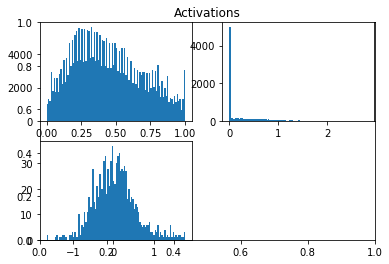

[9 2 2 2 2 2 9 2 9 9 2 2 2 9 2 9 9 2 2 2 2 9 9 9 9 2 2 9 9 9 2 2 9 2 9 2 2
 9 2 2 9 2 2 9 2 9 2 2 2 9 2 9 9 2 2 2 2 9 9 9 9 9 2 9 9 2 9 9 9 9 2 2 1 2
 2 9 9 9 2 9 2 9 2 2 2 2 2 2 9 9 9 9 2 9 2 2 9 2 9 9]
[ 0  1 52  0  0  0  0  0  0 47]
[2 2 9 ..., 2 2 2]
[   0   87 2484    0    2    6    2    0    0 2419]
cost: 24.477231775720966, train accuracy: 0.13, validation accuracy: 0.0846
iterations finished: 1 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.000131094674799 SD 0.0255247550911
Weights 1 Mean -0.00155329803455 SD 0.137946798657


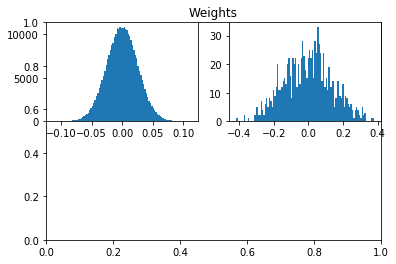

dW 0 Mean 0.148222203855 SD 0.879342371776
dW 1 Mean 7.1054273576e-17 SD 3.3596291727


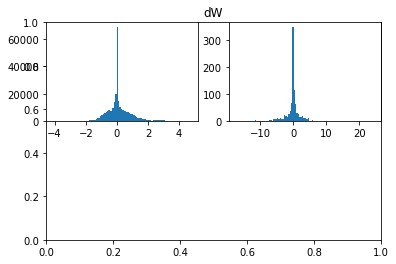

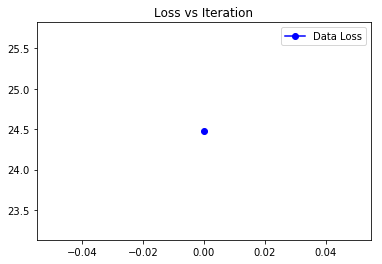

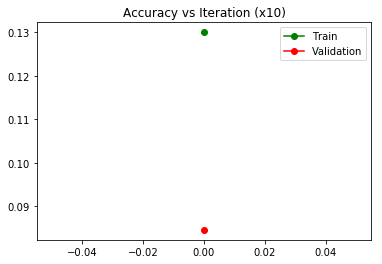

[0 5 0 5 0 4 0 0 4 4 0 0 0 3 0 0 0 6 6 0 4 4 0 4 5 0 0 0 3 0 0 0 0 3 0 0 6
 0 4 0 0 0 0 0 4 0 6 0 5 0 4 5 0 0 0 0 4 0 0 0 0 6 4 0 0 5 0 0 0 5 4 0 0 0
 4 4 3 0 0 0 0 4 3 0 0 4 0 3 4 0 5 0 0 6 4 0 0 0 4 0]
[61  0  0  6 19  8  6]
[6 0 0 ..., 5 4 5]
[3087    0    0  327  820  491  229    0   21   25]
cost: 23.365396728390923, train accuracy: 0.21, validation accuracy: 0.1532
iterations finished: 11 alpha: 0.001 reg. lambda: 0.0


[6 0 6 3 6 3 0 6 3 8 0 0 6 0 0 6 8 0 8 3 0 0 3 6 6 3 8 8 3 8 3 3 0 3 0 6 0
 6 6 3 3 6 6 6 6 6 0 6 3 3 0 6 6 6 8 6 6 3 8 3 0 4 6 6 0 3 4 6 8 0 8 6 3 4
 8 3 8 4 3 0 3 6 3 0 3 6 3 8 0 0 0 6 6 6 8 6 3 0 0 3]
[24  0  0 26  4  0 32  0 14]
[6 6 6 ..., 6 6 6]
[ 954   12    3  828  219   10 2299    3  671    1]
cost: 23.625500187689468, train accuracy: 0.17, validation accuracy: 0.1784
iterations finished: 21 alpha: 0.001 reg. lambda: 0.0


[4 0 0 4 0 8 0 0 4 8 4 3 0 8 0 0 6 4 4 3 4 6 3 4 0 6 0 3 8 4 0 8 3 3 0 4 8
 4 8 0 3 0 8 0 0 8 6 0 4 0 4 0 0 0 0 0 4 0 8 8 6 4 4 4 8 3 

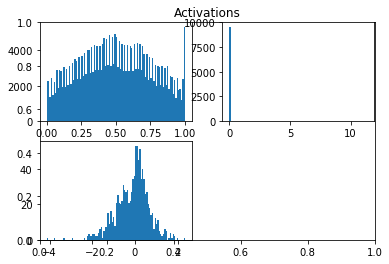

[6 5 8 8 9 8 9 9 5 7 6 9 9 8 1 5 8 0 8 3 5 8 8 8 0 9 8 5 8 6 5 8 6 5 6 5 5
 8 8 8 5 6 5 8 6 8 5 7 5 9 5 9 9 3 2 9 9 6 8 5 8 8 0 9 0 9 3 8 8 5 5 6 9 6
 9 8 0 5 5 9 8 5 8 8 9 9 8 5 8 9 9 8 5 5 6 5 0 5 6 5]
[ 6  1  1  3  0 26 12  2 29 20]
[6 8 8 ..., 5 5 5]
[ 396   39   64  130    3 1471  663  104 1485  645]
cost: 25.28172751010912, train accuracy: 0.41, validation accuracy: 0.249
iterations finished: 101 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.00115988747575 SD 0.0256588987715
Weights 1 Mean -0.00155329803455 SD 0.136919755961


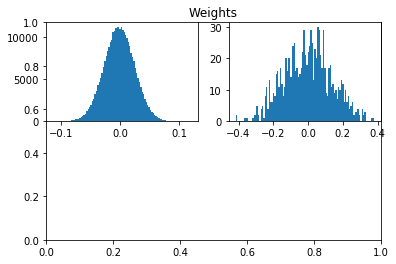

dW 0 Mean -0.031686528512 SD 0.217351085338
dW 1 Mean 0.0 SD 1.75600616034


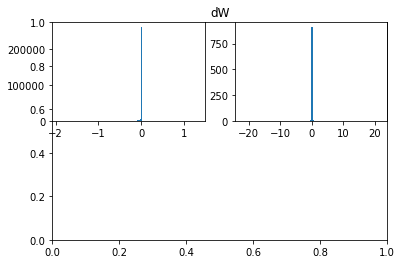

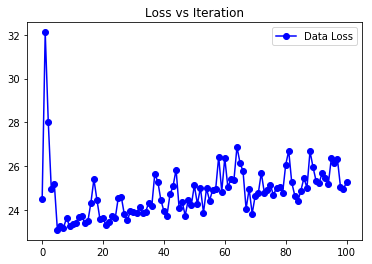

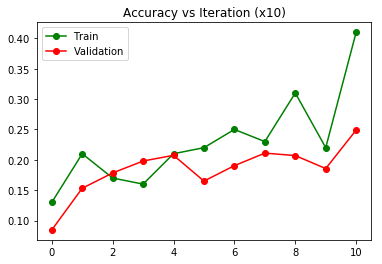

[4 6 9 6 8 4 6 9 0 7 0 8 6 6 6 5 7 5 4 4 4 9 7 0 9 9 7 7 5 7 0 7 9 9 7 7 4
 4 0 4 6 8 6 5 5 6 7 4 7 6 9 9 4 4 4 5 4 4 1 9 4 5 8 7 6 7 5 5 4 4 8 9 9 8
 4 7 9 6 7 9 4 4 7 0 4 7 6 6 9 4 5 9 7 7 7 9 8 4 4 4]
[ 6  1  0  0 25 10 14 20  7 17]
[6 8 4 ..., 6 4 6]
[ 379  107   26    0 1092  355  789  837  313 1102]
cost: 26.143935872177718, train accuracy: 0.38, validation accuracy: 0.2626
iterations finished: 111 alpha: 0.001 reg. lambda: 0.0


[0 0 0 8 4 0 4 5 0 4 0 0 4 9 5 5 0 0 0 5 0 0 4 5 0 0 0 4 8 0 0 6 0 0 4 0 8
 4 7 5 0 4 4 0 5 0 0 0 0 6 0 0 0 6 0 8 0 0 6 0 0 8 4 4 0 8 4 0 6 0 8 0 0 0
 8 0 6 4 4 4 5 0 4 0 5 4 2 0 0 0 8 0 5 5 4 8 0 4 0 5]
[49  0  1  0 20 12  6  1 10  1]
[6 0 0 ..., 0 0 5]
[2282    7   84    0  994  610  343   19  510  151]
cost: 25.738877131301276, train accuracy: 0.2, validation accuracy: 0.2188
iterations finished: 121 alpha: 0.001 reg. lambda: 0.0


[6 9 4 5 0 8 4 4 0 0 6 6 6 8 5 5 4 6 3 3 9 3 4 0 1 6 6 0 4 9 0 1 6 4 9 8 6
 6 0 4 2 4 4 0 6 0 6 6 0 9 8 0 6 6 9 0 1 4 9 0

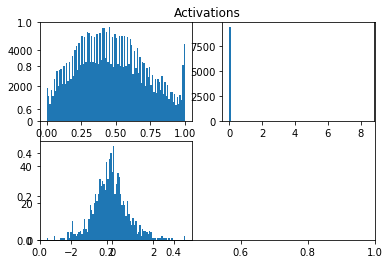

[4 7 1 4 0 6 7 9 5 7 7 0 8 0 9 5 5 9 8 9 8 1 7 9 9 5 6 7 5 0 9 5 9 7 5 6 9
 6 4 5 0 5 9 1 7 8 5 1 8 0 8 0 5 9 4 4 7 9 5 4 0 5 0 5 0 9 1 5 5 4 6 6 8 5
 7 5 0 5 6 6 5 9 4 1 5 7 6 0 7 9 1 6 5 5 8 5 8 4 8 5]
[12  7  0  0  9 25 10 12 10 15]
[5 8 4 ..., 5 5 5]
[ 570  330    4   26  474 1187  445  675  562  727]
cost: 26.097500358506068, train accuracy: 0.36, validation accuracy: 0.3068
iterations finished: 201 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.00116999724154 SD 0.0258119756028
Weights 1 Mean -0.00155329803455 SD 0.138942504969


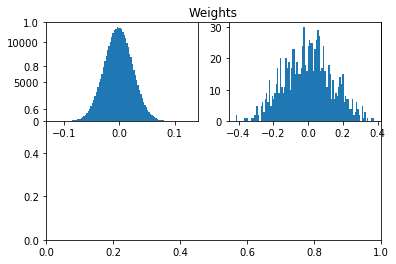

dW 0 Mean -0.0110046596244 SD 0.1655735023
dW 1 Mean 1.42108547152e-17 SD 1.419499281


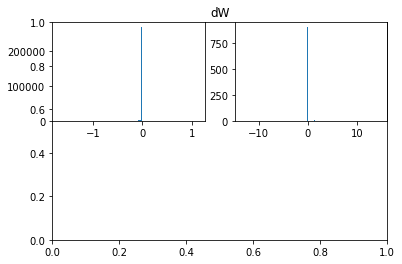

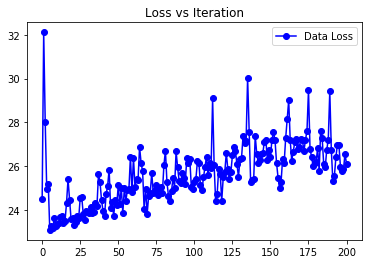

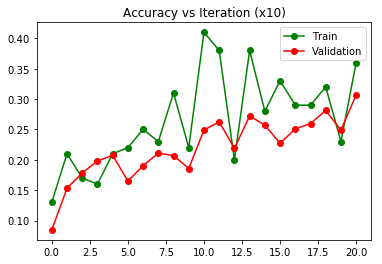

[0 6 9 9 0 7 8 8 7 7 7 2 9 0 5 9 7 4 2 4 8 4 9 4 9 7 9 9 7 9 7 4 2 7 1 0 1
 9 2 9 0 7 4 8 7 7 0 0 9 0 2 8 7 0 5 5 9 7 7 0 7 7 8 8 0 7 7 0 7 2 1 7 8 4
 0 7 4 5 4 9 9 7 7 8 4 9 2 6 7 5 9 4 7 6 2 9 7 6 5 0]
[14  3  8  0 11  6  4 27  9 18]
[6 8 4 ..., 5 7 4]
[ 522   90  251   34  477  326  475 1598  400  827]
cost: 26.447709015602797, train accuracy: 0.37, validation accuracy: 0.293
iterations finished: 211 alpha: 0.001 reg. lambda: 0.0


[6 5 8 0 1 4 4 9 9 9 9 8 0 0 4 9 5 7 9 8 0 7 5 9 6 6 4 9 9 4 4 9 6 9 9 0 9
 9 6 4 4 0 0 4 4 6 6 6 6 6 4 6 7 6 7 9 6 6 9 9 7 5 6 9 6 5 6 4 4 4 5 4 8 4
 9 0 9 6 6 4 4 0 8 6 6 6 9 7 8 6 6 6 1 6 7 9 9 9 6 5]
[ 9  2  0  0 18  7 27  7  6 24]
[6 4 6 ..., 5 4 6]
[ 255   96    7    2 1156  324 1264  412  329 1155]
cost: 27.6190045411345, train accuracy: 0.4, validation accuracy: 0.279
iterations finished: 221 alpha: 0.001 reg. lambda: 0.0


[4 7 8 8 1 0 8 8 0 4 4 7 4 4 8 8 8 6 7 8 8 8 4 0 8 8 1 8 8 2 4 8 8 8 8 8 8
 0 8 0 8 0 8 5 4 8 8 8 8 7 0 8 8 5 8 8 8 8 8 9 0 8

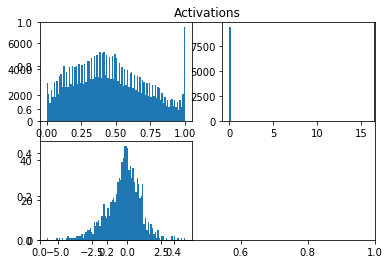

[9 6 7 6 5 6 9 0 5 3 8 7 5 8 6 1 1 5 6 8 9 6 6 9 6 9 6 8 5 6 9 9 9 5 9 6 7
 6 5 6 9 4 8 7 7 6 5 9 9 9 7 9 6 0 5 7 8 9 7 3 0 8 8 0 5 9 9 4 6 7 9 5 4 7
 8 5 9 7 5 4 4 6 8 9 4 8 0 6 8 6 9 1 6 6 7 6 6 8 1 4]
[ 5  4  0  2  7 13 23 12 13 21]
[6 1 6 ..., 5 3 6]
[ 290  281   27  285  305  454 1209  452  588 1109]
cost: 28.601912185601677, train accuracy: 0.34, validation accuracy: 0.3078
iterations finished: 301 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.00117306465462 SD 0.0259479983263
Weights 1 Mean -0.00155329803455 SD 0.139667758566


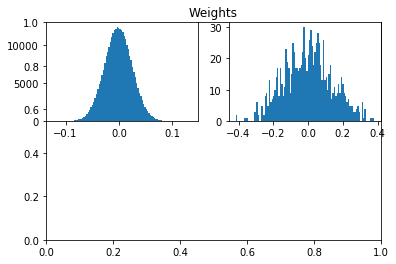

dW 0 Mean -0.00106212688366 SD 0.21841727914
dW 1 Mean 2.84217094304e-17 SD 2.65641539755


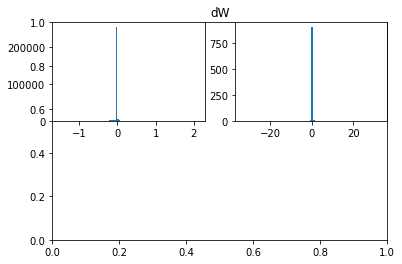

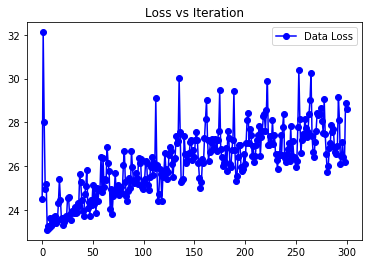

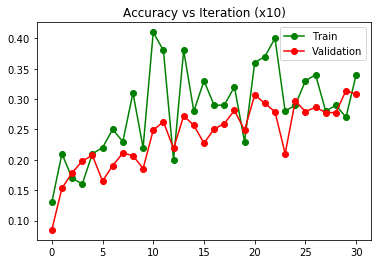

[6 8 4 6 9 6 5 9 7 9 6 5 8 5 9 8 6 6 9 6 9 5 4 9 8 5 5 6 9 7 8 8 8 4 7 6 6
 5 7 0 7 6 5 8 8 1 5 5 6 8 6 5 0 9 4 6 9 5 1 6 5 6 8 8 7 6 6 5 1 8 6 9 6 6
 9 9 4 9 9 5 8 6 6 8 1 1 5 6 9 8 5 1 7 6 2 5 0 9 5 8]
[ 3  6  1  0  5 19 25  7 17 17]
[6 1 6 ..., 5 5 6]
[ 177  351  112  103  171  896 1273  202  759  956]
cost: 28.85130227045329, train accuracy: 0.3, validation accuracy: 0.2946
iterations finished: 311 alpha: 0.001 reg. lambda: 0.0


[5 0 8 6 1 5 0 6 0 6 0 1 7 6 9 0 1 6 5 5 5 6 0 5 9 9 6 8 9 8 6 9 1 8 0 2 0
 6 1 6 6 6 8 6 0 9 1 6 5 0 6 1 8 0 1 1 5 1 6 8 0 6 8 5 6 1 6 5 5 1 0 9 6 6
 6 1 5 6 9 5 6 6 6 5 6 4 5 9 6 6 6 8 1 1 0 1 5 6 4 5]
[14 16  1  0  2 17 31  1  9  9]
[6 1 2 ..., 5 5 6]
[ 579  711  116   10  103  878 1261   57  547  738]
cost: 28.04545676000542, train accuracy: 0.34, validation accuracy: 0.2978
iterations finished: 321 alpha: 0.001 reg. lambda: 0.0


[9 9 8 9 6 1 8 4 9 9 4 4 7 4 4 9 4 7 8 4 0 4 0 9 4 9 4 7 0 4 4 4 4 7 4 9 4
 0 7 9 7 4 9 6 9 0 6 0 7 9 4 4 4 4 4 9 4 9 1 7 6

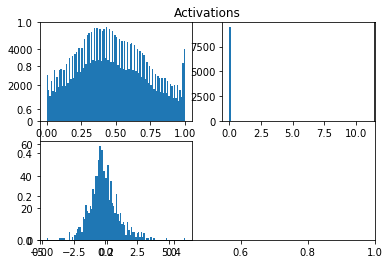

[5 5 1 4 5 8 9 5 5 8 4 8 3 5 6 9 2 6 8 6 8 2 3 5 0 5 6 5 8 6 4 8 1 9 9 1 8
 5 8 8 5 8 5 8 4 8 0 6 9 3 3 0 6 5 3 5 8 8 0 8 2 2 7 1 2 5 5 5 9 8 9 3 1 0
 2 9 4 4 0 8 8 8 6 5 7 7 5 0 5 5 8 0 8 8 8 5 8 9 6 4]
[ 8  5  6  6  7 22  9  3 25  9]
[5 1 2 ..., 5 3 6]
[ 383  419  196  606  544  560  499  297 1006  490]
cost: 28.30742088332164, train accuracy: 0.37, validation accuracy: 0.3264
iterations finished: 401 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.0011850621032 SD 0.0260798384366
Weights 1 Mean -0.00155329803455 SD 0.140388459576


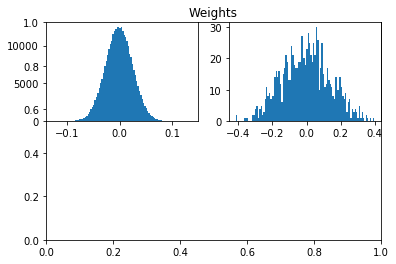

dW 0 Mean -0.00502290678084 SD 0.17576634462
dW 1 Mean -2.84217094304e-17 SD 2.02978047565


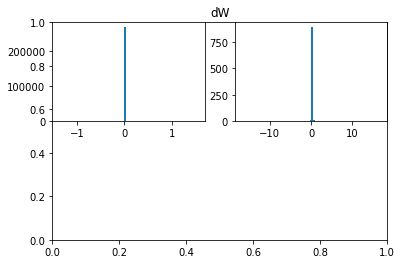

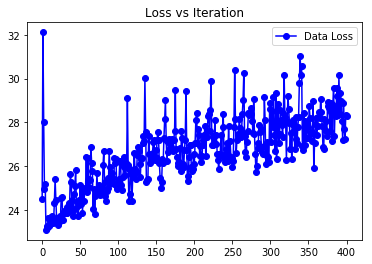

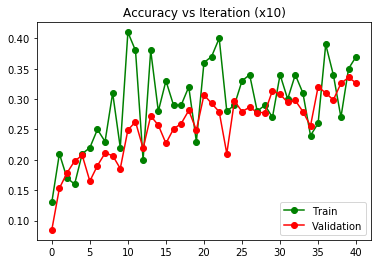

[3 4 3 2 2 4 8 6 8 3 0 1 2 6 7 6 7 8 9 0 0 3 2 1 6 0 6 8 9 9 6 3 9 9 3 9 9
 6 8 3 9 9 8 6 9 3 3 3 0 8 7 6 5 8 0 3 9 6 3 8 1 8 3 9 9 9 5 8 9 9 6 6 8 6
 8 9 5 1 0 8 8 9 6 8 9 8 5 3 6 8 3 9 3 9 0 9 3 5 8 8]
[ 8  4  4 17  2  5 15  3 20 22]
[5 8 8 ..., 3 3 3]
[ 393  522   37 1095  163  241  450  155 1109  835]
cost: 28.65500589592883, train accuracy: 0.35, validation accuracy: 0.2874
iterations finished: 411 alpha: 0.001 reg. lambda: 0.0


[5 6 5 7 8 7 7 6 7 9 7 1 8 9 9 5 6 6 5 1 5 6 7 9 7 8 9 8 5 9 9 5 5 0 6 9 9
 5 9 8 7 9 8 5 7 6 8 7 5 5 6 6 9 8 6 1 5 8 0 8 1 6 8 9 9 8 5 6 9 6 7 9 9 5
 8 8 9 5 6 6 0 0 1 5 9 5 1 1 5 6 7 8 7 8 6 4 9 1 8 4]
[ 4  8  0  0  2 19 17 13 17 20]
[5 1 6 ..., 5 5 6]
[153 603   4 193  68 880 904 446 821 928]
cost: 28.560335765409175, train accuracy: 0.32, validation accuracy: 0.3024
iterations finished: 421 alpha: 0.001 reg. lambda: 0.0


[3 7 0 5 8 3 6 9 5 5 5 9 9 8 1 6 7 1 6 7 3 0 1 6 3 1 7 1 5 5 4 5 7 5 1 5 3
 8 9 8 9 8 6 6 5 1 8 6 6 6 7 4 5 0 4 5 9 5 8 7 7 6 8 0 0

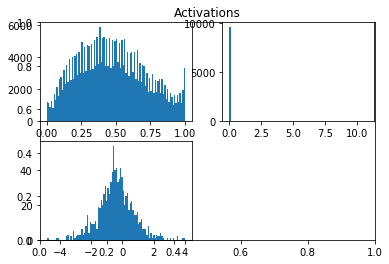

[6 8 0 6 5 0 9 7 5 0 7 0 9 5 4 5 5 0 9 6 0 6 5 5 6 0 5 0 8 5 5 0 9 5 0 7 3
 0 4 0 4 8 1 0 0 0 1 6 4 4 5 5 5 1 0 6 5 5 6 5 6 8 0 5 8 4 6 0 6 0 5 6 7 5
 0 4 5 6 5 5 7 0 1 8 5 7 6 0 5 7 8 5 5 0 8 7 7 0 8 9]
[24  4  0  1  7 27 14  9  9  5]
[5 8 5 ..., 5 5 6]
[ 870  250   56   66  356 1549  515  508  465  365]
cost: 28.248811009085966, train accuracy: 0.32, validation accuracy: 0.3174
iterations finished: 501 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00123329650863 SD 0.0262145086407
Weights 1 Mean -0.00155329803455 SD 0.141420093318


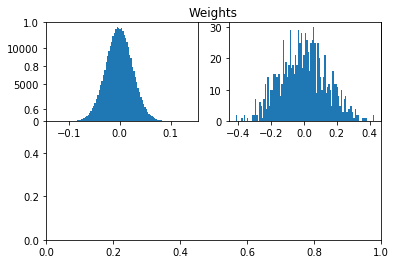

dW 0 Mean -0.00274873106232 SD 0.232807871024
dW 1 Mean -7.1054273576e-18 SD 1.98930081339


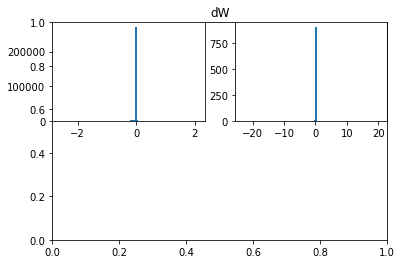

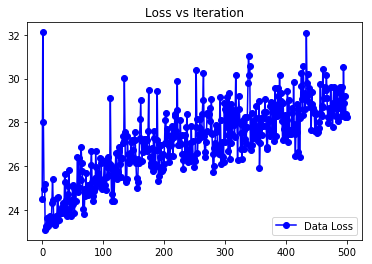

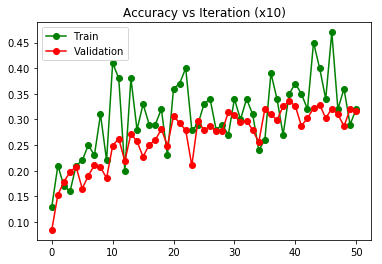

[0 6 6 6 6 9 3 5 6 1 7 6 1 6 6 6 1 6 3 6 7 8 5 1 6 6 5 1 9 6 3 8 1 3 7 1 8
 6 9 8 6 8 6 8 8 8 6 6 6 6 9 4 6 9 1 9 8 9 2 8 6 5 1 1 8 2 9 8 4 5 6 8 6 8
 3 4 6 6 6 9 6 1 1 3 1 8 3 6 6 6 1 0 8 8 6 2 8 6 6 3]
[ 2 14  3  8  3  5 35  3 18  9]
[6 1 6 ..., 3 3 6]
[ 193  738  121  252  132  320 1525  194  735  790]
cost: 29.34223840343858, train accuracy: 0.38, validation accuracy: 0.3034
iterations finished: 511 alpha: 0.0009000000000000001 reg. lambda: 0.0


[5 3 5 0 5 9 9 7 5 0 9 8 6 0 9 8 5 8 1 1 7 9 6 9 0 8 4 9 6 7 0 4 0 0 9 1 4
 9 9 5 0 7 6 7 6 6 7 7 5 8 8 9 7 3 9 4 0 0 7 9 7 7 7 1 5 0 4 6 4 5 6 4 6 4
 9 8 4 8 6 9 4 5 7 7 8 0 0 6 6 6 1 4 4 5 9 7 9 4 7 6]
[13  5  0  2 13 11 14 16  9 17]
[6 1 4 ..., 5 5 4]
[478 402   8  99 748 478 662 730 436 959]
cost: 29.124839575599264, train accuracy: 0.44, validation accuracy: 0.337
iterations finished: 521 alpha: 0.0009000000000000001 reg. lambda: 0.0


[7 5 4 4 4 4 1 9 4 5 5 4 1 8 1 9 7 0 0 4 7 0 4 4 6 4 4 8 0 8 5 0 0 4 4 8 8
 0 1 9 9 7 4 1 4 7 7 5 9 

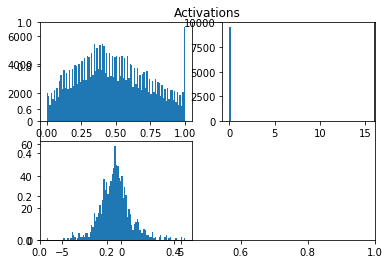

[5 5 5 8 7 6 5 6 5 9 7 0 0 5 3 7 5 8 7 5 8 0 0 3 7 5 7 9 3 6 3 3 5 6 4 8 0
 0 0 7 9 8 4 9 9 7 7 3 4 8 0 3 7 3 0 3 7 6 6 9 7 0 6 3 6 7 5 5 9 6 2 3 4 1
 6 3 9 5 6 6 7 0 2 3 7 8 5 6 5 4 4 5 1 5 0 6 9 6 7 4]
[12  2  2 13  7 17 15 16  7  9]
[5 5 6 ..., 5 3 6]
[411 233 102 499 282 842 815 828 560 428]
cost: 30.385409112830647, train accuracy: 0.38, validation accuracy: 0.3386
iterations finished: 601 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00119915126896 SD 0.0263229510531
Weights 1 Mean -0.00155329803455 SD 0.141953556292


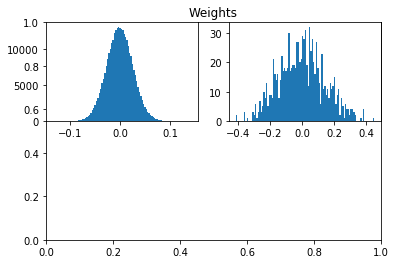

dW 0 Mean 5.34066853844e-05 SD 0.294559262085
dW 1 Mean 3.19744231092e-17 SD 2.0456997644


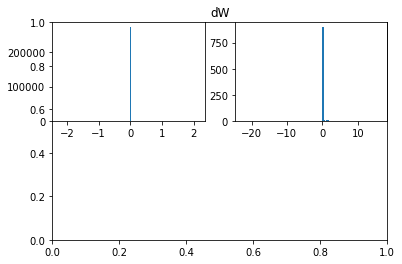

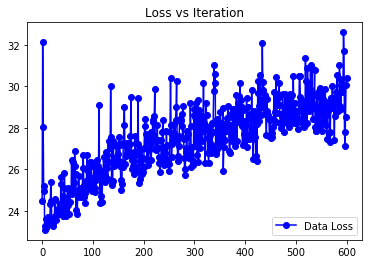

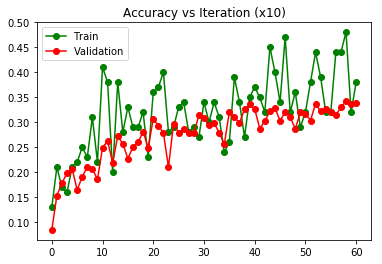

[5 9 3 6 8 7 6 6 6 7 6 8 1 7 8 9 9 7 1 7 4 6 2 0 5 5 9 8 5 6 9 4 0 8 1 9 1
 6 7 7 9 4 2 5 7 7 5 7 6 0 5 6 6 3 7 8 7 9 6 7 5 8 9 6 7 0 9 0 7 6 8 4 7 6
 8 2 4 9 4 8 1 0 6 9 9 6 9 5 4 9 6 9 5 4 6 6 1 5 6 5]
[ 6  6  3  2  8 12 21 16 10 16]
[6 1 6 ..., 5 5 6]
[ 253  381  132  116  310  666 1242  671  495  734]
cost: 30.403762874918822, train accuracy: 0.38, validation accuracy: 0.3294
iterations finished: 611 alpha: 0.0009000000000000001 reg. lambda: 0.0


[0 0 9 5 5 5 7 9 9 3 5 3 9 9 3 6 0 9 0 0 3 6 0 0 7 9 9 6 3 0 5 6 6 7 7 7 3
 9 0 8 0 5 6 0 3 0 7 3 6 5 2 5 3 9 8 5 7 7 5 6 9 9 7 9 5 0 9 0 5 0 9 9 6 6
 0 1 6 8 0 5 1 7 0 7 0 0 7 3 0 9 7 9 9 0 0 9 3 9 0 0]
[25  2  1 11  0 13 11 13  3 21]
[5 1 6 ..., 5 3 6]
[832 242  24 548 280 472 445 929 398 830]
cost: 30.78508300917203, train accuracy: 0.45, validation accuracy: 0.3398
iterations finished: 621 alpha: 0.0009000000000000001 reg. lambda: 0.0


[0 1 7 8 9 2 2 6 2 6 6 1 8 5 2 7 9 0 5 0 0 2 3 2 1 0 6 5 1 2 0 2 2 6 0 4 6
 1 0 2 5 1 5 7 4 0 4 2 6

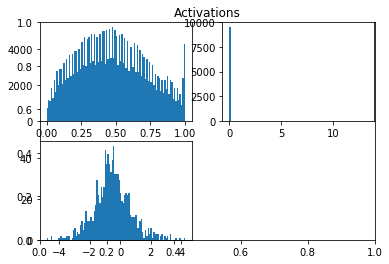

[5 5 8 5 6 4 7 9 3 5 8 9 0 5 0 1 6 6 8 6 5 5 1 6 3 5 9 5 5 5 5 1 5 5 6 7 5
 4 8 9 6 5 6 7 8 0 8 5 8 8 5 9 7 9 6 3 9 9 3 9 5 0 4 5 5 5 0 5 9 5 5 8 6 9
 5 5 5 5 4 4 5 5 5 1 6 5 8 5 5 6 4 1 7 9 5 5 1 7 5 5]
[ 5  6  0  4  6 39 12  6 10 12]
[5 1 5 ..., 5 5 6]
[ 353  401   36  242  159 2019  540  196  588  466]
cost: 29.370216624259974, train accuracy: 0.34, validation accuracy: 0.3068
iterations finished: 701 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.0011880104902 SD 0.0264275726347
Weights 1 Mean -0.00155329803455 SD 0.142460692097


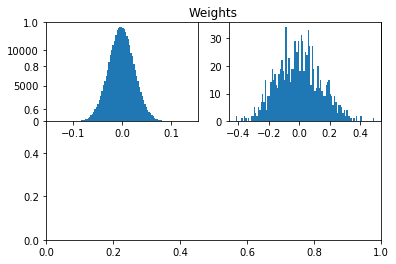

dW 0 Mean -0.00661297991768 SD 0.284001173658
dW 1 Mean -3.5527136788e-17 SD 1.85878633068


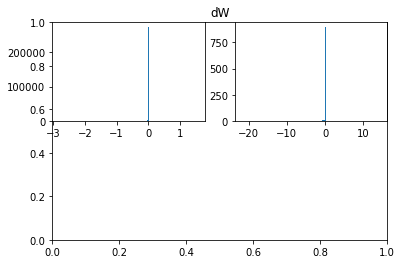

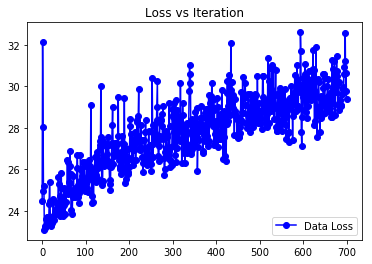

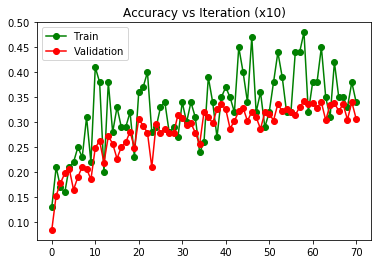

[6 1 6 5 6 6 8 7 9 2 4 7 4 4 9 4 4 4 2 0 5 7 6 9 7 2 2 7 9 4 4 6 2 6 8 7 6
 4 7 8 2 4 7 6 9 8 7 5 4 7 6 5 6 4 6 9 6 4 6 0 6 4 8 7 4 6 4 2 4 4 6 6 0 2
 5 4 6 2 5 7 6 1 6 7 1 5 4 7 6 7 5 8 7 7 2 4 7 5 4 7]
[ 3  3 10  0 22  9 22 19  6  6]
[6 1 6 ..., 5 2 6]
[243 312 706  38 611 535 857 572 787 339]
cost: 29.453755369051645, train accuracy: 0.38, validation accuracy: 0.3324
iterations finished: 711 alpha: 0.0009000000000000001 reg. lambda: 0.0


[6 3 6 7 8 9 7 9 7 6 8 8 7 8 8 6 8 5 0 5 7 6 8 0 1 0 1 6 9 8 8 8 9 0 1 8 7
 8 7 7 6 4 2 7 4 5 5 1 2 9 8 5 3 6 1 7 0 0 8 9 1 1 7 0 5 4 8 0 1 3 8 1 8 7
 7 1 1 7 6 0 5 6 4 9 9 1 6 0 9 1 8 5 6 8 6 8 9 5 4 7]
[10 13  2  3  5  9 13 15 20 10]
[6 1 4 ..., 5 3 6]
[494 679 243 198 277 507 653 618 861 470]
cost: 30.397357353652225, train accuracy: 0.38, validation accuracy: 0.357
iterations finished: 721 alpha: 0.0009000000000000001 reg. lambda: 0.0


[5 9 7 8 2 1 8 0 8 0 5 0 4 8 6 7 6 1 7 5 1 1 7 2 4 5 2 5 1 2 6 2 0 9 5 9 2
 5 7 6 2 0 5 0 7 2 1 2 6 0 2 6 5 2

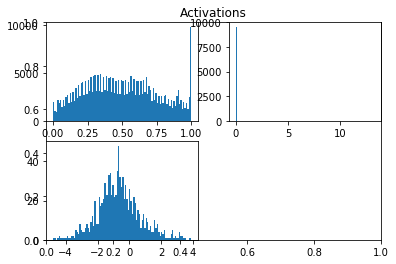

[1 0 2 7 4 6 2 2 7 6 5 0 1 7 6 8 2 8 0 9 2 2 2 5 7 8 9 6 0 6 0 9 8 8 9 8 6
 2 6 7 7 9 3 5 8 6 8 9 4 7 1 6 8 5 1 7 9 8 7 9 9 2 2 8 9 7 8 2 7 2 9 5 8 2
 5 9 9 4 9 9 5 8 9 9 2 2 9 8 6 0 8 1 1 7 3 7 8 4 7 2]
[ 6  6 16  2  4  7 10 14 17 18]
[5 1 6 ..., 5 2 6]
[ 303  357  510  117  115  409  621 1175  655  738]
cost: 30.529489008385763, train accuracy: 0.47, validation accuracy: 0.3412
iterations finished: 801 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00117938539733 SD 0.0265314917822
Weights 1 Mean -0.00155329803455 SD 0.142812596953


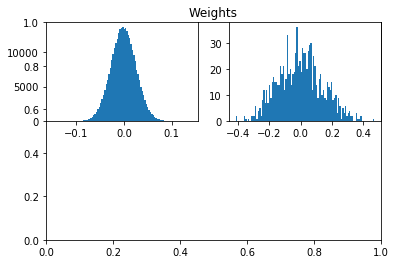

dW 0 Mean -0.00784635309407 SD 0.188880866431
dW 1 Mean 0.0 SD 2.00562280665


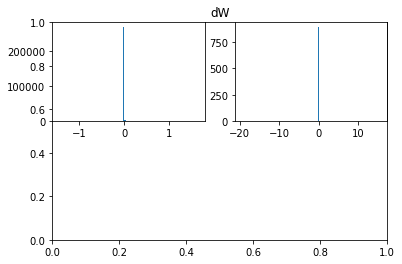

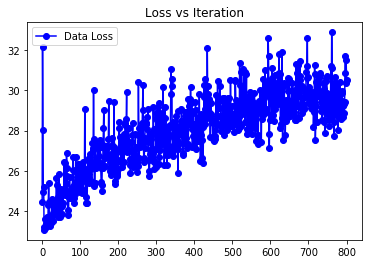

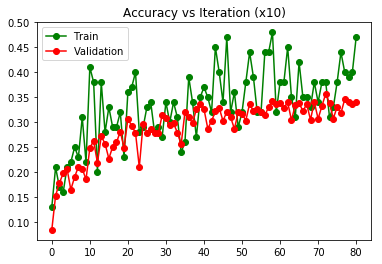

[9 0 7 1 0 9 7 3 7 4 8 1 0 9 7 1 0 2 1 1 2 8 1 7 1 0 1 0 8 7 7 6 1 8 8 0 7
 0 7 7 1 4 6 0 7 3 7 5 3 7 3 3 4 0 1 7 7 0 3 3 1 3 7 3 8 8 3 4 3 7 7 6 3 0
 2 8 3 7 4 0 6 0 3 4 1 7 5 7 7 7 7 3 7 5 6 8 7 8 1 0]
[15 14  3 15  6  3  5 26 10  3]
[3 1 6 ..., 5 3 6]
[889 756 203 613 419 267 358 909 419 167]
cost: 29.603074070394015, train accuracy: 0.36, validation accuracy: 0.3518
iterations finished: 811 alpha: 0.0009000000000000001 reg. lambda: 0.0


[8 0 4 6 0 9 8 6 8 4 7 4 6 7 3 6 5 7 0 8 4 0 4 0 4 8 7 6 8 8 4 9 4 0 9 0 1
 7 9 1 6 4 4 6 6 0 7 4 1 6 9 7 6 0 4 5 7 7 5 0 6 7 3 6 5 5 7 4 7 6 4 3 6 6
 2 6 1 4 8 8 9 7 4 8 7 7 1 7 9 9 7 4 6 4 9 8 8 7 0 8]
[11  5  1  3 18  5 17 18 13  9]
[6 1 6 ..., 5 2 6]
[283 416 186 151 771 182 688 988 825 510]
cost: 30.978341103224675, train accuracy: 0.37, validation accuracy: 0.3442
iterations finished: 821 alpha: 0.0009000000000000001 reg. lambda: 0.0


[3 9 5 1 9 9 9 0 8 3 1 6 3 2 3 6 6 6 9 1 0 9 1 9 6 1 3 0 9 0 3 8 6 3 8 1 0
 0 8 3 3 1 0 6 1 1 1 6 9 1 3 5 1 

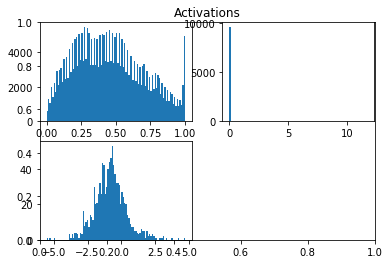

[6 6 5 6 9 6 3 1 0 3 3 8 9 4 7 9 6 8 5 1 4 8 6 3 5 7 1 6 4 1 9 3 0 1 3 0 9
 4 4 7 4 0 9 4 4 4 0 0 4 3 0 1 0 8 6 4 3 9 5 9 3 8 3 6 0 8 1 0 0 4 6 3 0 8
 5 6 0 3 4 7 3 8 4 1 0 9 3 5 2 6 9 1 8 9 0 5 5 9 6 9]
[15  9  1 14 14  8 13  4  9 13]
[5 1 6 ..., 5 3 6]
[479 373 136 665 631 565 505 243 604 799]
cost: 28.89565723254511, train accuracy: 0.4, validation accuracy: 0.3526
iterations finished: 901 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00119594005166 SD 0.0266428959347
Weights 1 Mean -0.00155329803455 SD 0.143006290684


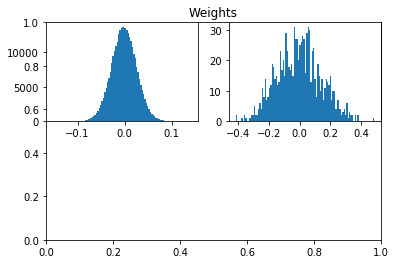

dW 0 Mean -0.0342414630373 SD 0.190192443379
dW 1 Mean -1.42108547152e-17 SD 2.21526026488


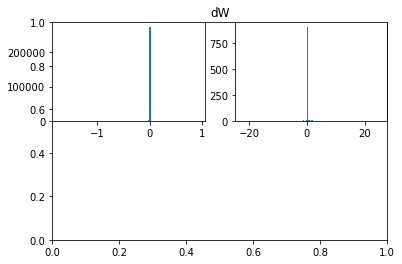

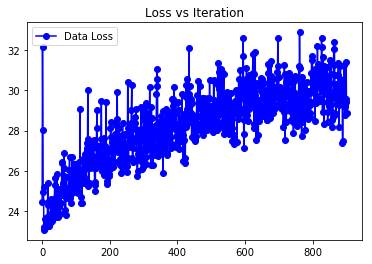

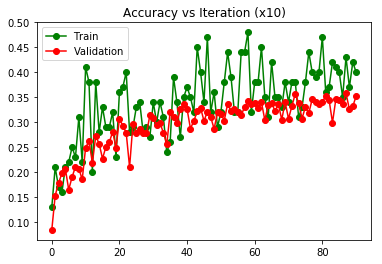

[4 5 8 1 4 9 4 4 4 3 5 2 5 9 4 4 6 4 8 4 4 4 6 6 3 8 8 0 5 4 4 8 6 4 7 5 8
 0 2 0 4 8 8 6 5 4 7 3 4 4 9 6 9 5 3 0 2 5 1 2 0 6 6 2 4 8 7 7 7 4 5 8 4 3
 7 2 4 4 4 4 3 0 2 6 9 4 1 4 6 4 6 8 4 3 0 7 9 8 5 7]
[ 7  3  7  7 29 10 11  8 12  6]
[5 7 6 ..., 5 5 4]
[ 387  221  356  208 1320  551  697  346  631  283]
cost: 31.195274953060856, train accuracy: 0.35, validation accuracy: 0.329
iterations finished: 911 alpha: 0.0009000000000000001 reg. lambda: 0.0


[6 5 6 3 7 0 6 3 4 6 6 6 6 4 5 7 6 0 5 1 1 3 3 8 7 5 6 6 6 5 0 6 5 8 0 4 1
 0 6 8 9 8 0 7 1 4 3 0 3 0 5 9 6 3 6 4 5 6 5 3 5 6 5 6 6 8 6 6 6 5 8 6 5 5
 4 6 7 6 3 6 6 3 1 5 8 3 0 9 3 0 7 6 1 8 3 1 4 8 5 8]
[10  7  0 13  7 16 28  6 10  3]
[5 1 6 ..., 5 3 6]
[ 591  441   83  690  235  689 1102  447  429  293]
cost: 29.80705755802298, train accuracy: 0.33, validation accuracy: 0.3446
iterations finished: 921 alpha: 0.0009000000000000001 reg. lambda: 0.0


[0 8 5 1 9 8 7 5 6 5 4 8 8 8 1 5 6 0 9 6 1 5 1 4 8 4 0 6 9 8 7 6 9 4 7 8 6
 8 8 5 0 6 9 1 

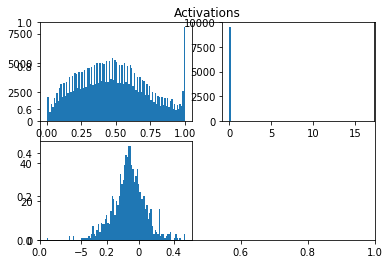

[0 0 1 1 1 4 8 4 9 6 3 1 4 9 1 5 2 4 4 4 9 5 5 6 0 9 4 0 1 0 9 4 2 5 4 9 1
 6 8 9 6 8 0 9 8 0 1 6 0 7 5 0 6 0 1 4 0 7 7 8 6 7 7 0 6 1 8 0 6 0 0 0 6 0
 9 2 9 9 9 6 6 2 0 9 4 4 1 4 5 3 6 4 6 7 6 1 8 6 3 2]
[18 12  5  3 14  6 16  6  7 13]
[6 1 6 ..., 5 2 6]
[903 556 170 194 574 232 776 541 393 661]
cost: 30.86301462767383, train accuracy: 0.4, validation accuracy: 0.3568
iterations finished: 1001 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00117961143792 SD 0.0267420666709
Weights 1 Mean -0.00155329803455 SD 0.143678753928


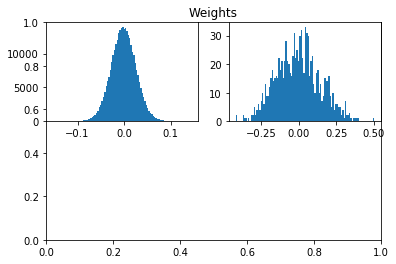

dW 0 Mean 0.0075578854943 SD 0.169669348685
dW 1 Mean 7.1054273576e-18 SD 1.70823128032


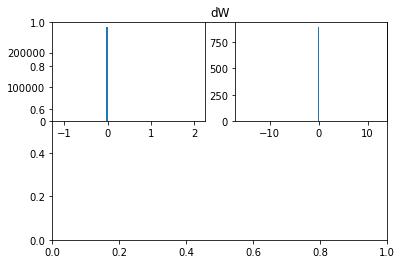

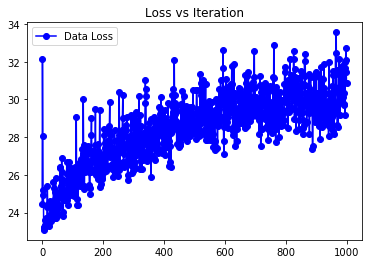

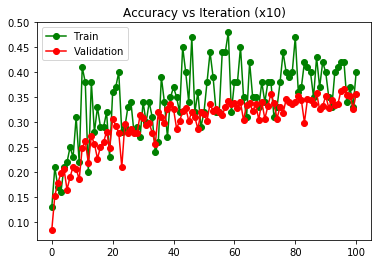

[5 9 8 8 5 4 5 5 7 0 0 0 7 9 2 3 5 3 0 9 5 8 1 0 3 5 8 3 5 6 5 0 6 7 2 1 9
 5 7 5 5 5 1 1 9 3 5 1 0 0 2 5 9 9 5 4 4 6 1 0 0 8 8 1 7 3 1 3 5 5 9 5 5 0
 5 1 5 2 8 6 4 9 1 3 0 5 4 2 8 4 3 1 3 5 4 8 1 9 9 8]
[12 12  5 10  7 24  4  5 10 11]
[5 1 5 ..., 5 5 6]
[ 678  433  529  234  319 1025  343  384  754  301]
cost: 29.822936456296738, train accuracy: 0.47, validation accuracy: 0.3592
iterations finished: 1011 alpha: 0.0008100000000000001 reg. lambda: 0.0


[5 5 0 5 6 4 7 5 6 4 1 6 3 3 8 0 1 4 9 7 9 8 9 7 7 4 6 4 7 6 6 6 9 5 0 6 6
 6 6 1 4 7 6 9 3 5 5 6 9 6 6 7 6 5 6 8 0 1 1 3 0 5 9 0 6 7 9 0 2 4 0 6 0 6
 8 9 5 2 6 9 8 5 0 0 6 6 5 1 2 6 8 9 6 9 2 3 1 9 7 6]
[11  7  4  5  7 12 26  9  6 13]
[5 1 6 ..., 5 3 6]
[ 378  385  178  590  309  509 1071  592  165  823]
cost: 31.184049439283122, train accuracy: 0.39, validation accuracy: 0.344
iterations finished: 1021 alpha: 0.0008100000000000001 reg. lambda: 0.0


[1 7 8 6 4 9 3 3 5 9 9 9 8 8 8 8 1 8 3 9 0 7 9 9 9 7 3 7 6 5 3 7 6 3 8 7 9
 5 8 5 5 9 5

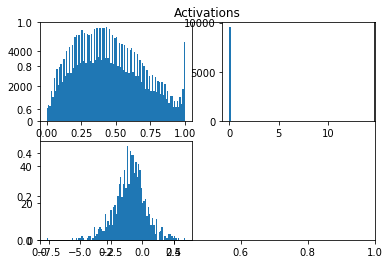

[6 3 2 9 9 9 1 6 9 1 9 6 8 7 9 7 2 9 5 9 7 1 0 1 8 0 5 6 6 6 2 0 7 8 4 8 1
 7 7 5 9 2 1 4 5 1 6 0 7 2 6 6 9 5 1 8 7 9 6 6 6 9 8 7 6 3 2 5 1 8 0 4 1 1
 7 7 4 1 6 2 9 2 7 5 0 0 1 7 3 2 5 5 2 7 9 7 9 7 8 5]
[ 7 13 10  3  4 10 14 16  8 15]
[5 1 6 ..., 5 3 6]
[394 634 427 435 122 457 580 735 354 862]
cost: 29.11275342888127, train accuracy: 0.4, validation accuracy: 0.356
iterations finished: 1101 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00116944876977 SD 0.0268114317674
Weights 1 Mean -0.00155329803455 SD 0.144067016302


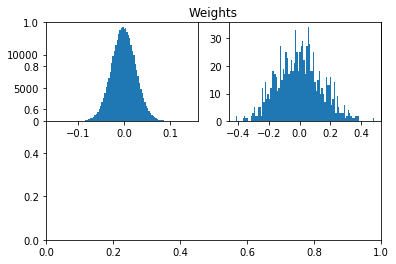

dW 0 Mean -0.0242188135459 SD 0.184153175243
dW 1 Mean 1.7763568394e-18 SD 1.53764757185


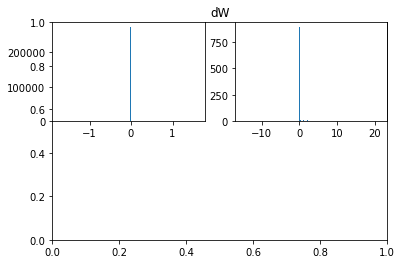

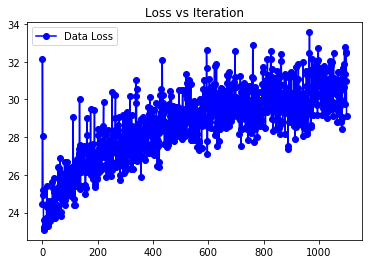

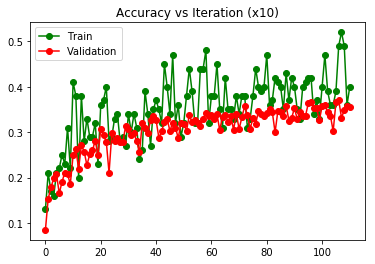

[3 4 4 4 5 1 4 5 0 3 4 9 7 7 8 0 6 0 4 4 6 1 0 2 4 1 9 3 4 9 5 6 5 1 0 1 1
 4 7 4 2 9 5 0 4 4 1 9 6 6 4 9 6 4 4 3 3 0 9 4 6 7 0 9 4 4 7 4 6 1 9 5 2 4
 3 4 8 9 6 4 9 0 8 0 7 4 8 1 8 8 7 5 4 1 7 4 7 4 0 4]
[11 10  3  6 28  7  9  9  6 11]
[4 1 6 ..., 5 4 6]
[ 469  408  127  397 1484  354  510  369  304  578]
cost: 33.26052163057839, train accuracy: 0.44, validation accuracy: 0.346
iterations finished: 1111 alpha: 0.0008100000000000001 reg. lambda: 0.0


[2 0 9 9 6 7 0 0 4 4 1 7 3 1 1 0 5 1 0 2 0 0 3 3 6 0 0 9 0 7 6 5 3 3 0 0 0
 2 6 0 0 6 4 4 1 0 3 0 0 0 0 0 9 4 0 7 6 5 3 3 0 6 9 5 0 8 8 3 8 1 5 7 4 9
 5 5 9 2 0 1 7 5 9 4 9 3 3 4 0 5 0 1 4 6 5 2 3 6 7 0]
[28  8  5 12  9 10  9  7  3  9]
[5 1 6 ..., 5 3 6]
[911 524 300 603 298 717 323 574 375 375]
cost: 30.26831829458056, train accuracy: 0.31, validation accuracy: 0.3554
iterations finished: 1121 alpha: 0.0008100000000000001 reg. lambda: 0.0


[7 0 0 8 1 6 1 3 1 9 0 7 6 0 8 3 8 5 9 5 8 1 9 8 7 8 4 5 4 8 0 0 5 6 6 8 6
 0 9 6 9 4 8 0 9 9 1 4 5

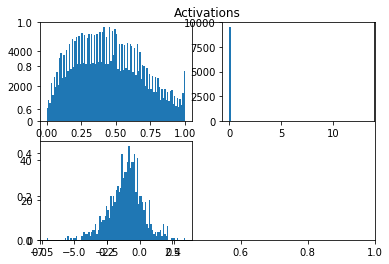

[4 4 2 7 4 0 7 6 9 5 8 0 1 8 6 5 0 6 9 1 1 5 6 5 5 5 1 6 4 4 6 7 6 6 4 7 1
 6 6 2 5 1 8 9 0 4 5 5 7 0 6 2 2 2 5 7 1 5 6 0 0 4 7 7 7 1 5 7 0 9 9 5 7 8
 9 2 1 6 8 1 4 0 6 4 5 7 9 0 1 4 0 5 3 2 7 5 2 4 1 8]
[11 12  8  1 12 16 14 13  6  7]
[6 1 6 ..., 5 5 6]
[617 675 320  41 379 676 744 692 465 391]
cost: 29.620735244193092, train accuracy: 0.41, validation accuracy: 0.375
iterations finished: 1201 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00114941535146 SD 0.0268973752657
Weights 1 Mean -0.00155329803455 SD 0.144865751917


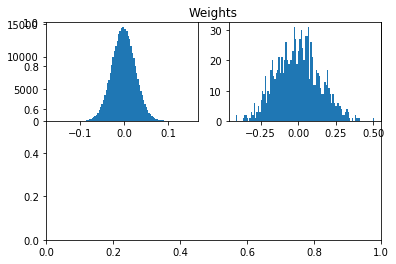

dW 0 Mean -0.0236979708266 SD 0.185057473232
dW 1 Mean -1.42108547152e-17 SD 1.93189794198


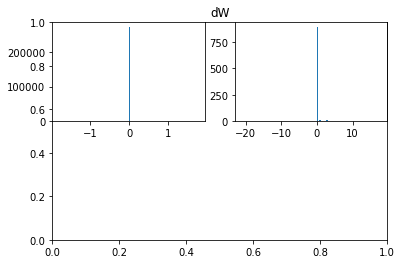

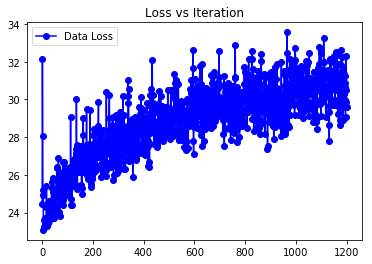

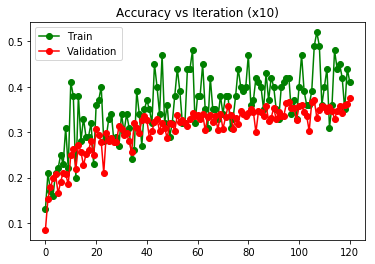

[8 5 4 3 2 1 2 6 0 1 8 8 2 6 4 9 9 1 7 8 3 5 8 3 8 1 1 7 3 8 3 7 4 4 8 6 1
 7 9 8 9 1 6 0 7 4 4 4 8 8 1 5 1 3 6 7 5 8 5 2 8 1 1 0 8 4 5 1 9 0 5 7 1 3
 5 4 9 1 6 7 5 2 7 0 6 8 3 7 7 2 6 5 0 8 4 1 4 8 6 6]
[ 6 15  6  8 11 10 10 11 17  6]
[5 1 5 ..., 5 3 6]
[415 899 114 495 274 570 691 468 731 343]
cost: 33.12704365789751, train accuracy: 0.47, validation accuracy: 0.3614
iterations finished: 1211 alpha: 0.0008100000000000001 reg. lambda: 0.0


[4 3 0 6 9 9 3 5 6 1 1 5 6 1 7 3 4 1 8 3 4 1 8 7 2 8 8 8 2 5 1 8 3 6 9 2 2
 7 4 8 3 5 6 8 6 9 1 6 8 6 8 0 9 0 8 1 9 4 8 9 6 2 4 2 3 8 0 1 1 9 2 6 4 4
 6 8 8 8 0 5 5 3 0 8 9 5 8 8 8 8 3 8 2 4 3 2 0 4 8 8]
[ 7 10  9 10 10  7 11  3 24  9]
[6 1 6 ..., 5 3 6]
[ 324  485  384  462  338  281  849  426 1118  333]
cost: 30.75886643397043, train accuracy: 0.38, validation accuracy: 0.3676
iterations finished: 1221 alpha: 0.0008100000000000001 reg. lambda: 0.0


[2 8 1 6 3 7 5 4 6 0 1 2 9 2 2 0 8 4 7 5 8 9 8 8 9 6 1 4 3 0 2 0 9 1 2 7 8
 8 8 3 8 9 9 7 7 8 4 0 

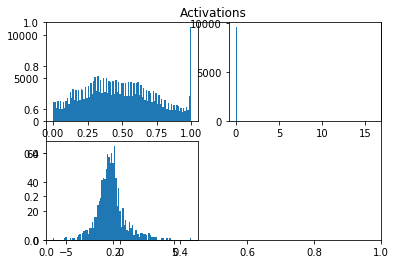

[8 5 2 3 6 0 5 8 1 0 5 1 6 4 1 8 2 4 1 6 1 8 0 2 0 0 9 2 1 0 8 1 2 3 1 1 0
 8 6 4 4 5 8 8 9 8 3 3 9 0 4 7 0 1 5 5 7 0 9 1 8 8 5 5 0 1 1 1 3 8 5 0 1 6
 3 8 5 6 0 9 6 6 8 5 1 1 1 7 8 3 0 6 3 2 1 6 3 1 1 4]
[14 21  6  9  6 11 10  3 15  5]
[3 1 6 ..., 5 3 6]
[755 778 289 579 439 468 618 233 568 273]
cost: 29.948383372644038, train accuracy: 0.43, validation accuracy: 0.3538
iterations finished: 1301 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00121277855303 SD 0.0269742606711
Weights 1 Mean -0.00155329803455 SD 0.145205360429


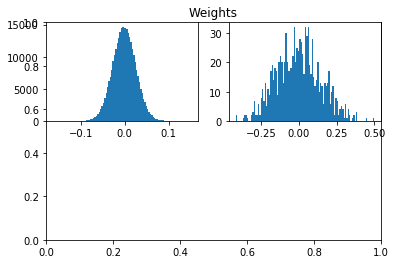

dW 0 Mean 0.00329507936326 SD 0.309109185336
dW 1 Mean 0.0 SD 3.12414649949


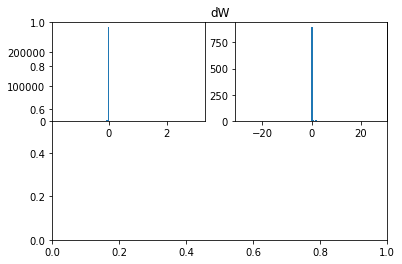

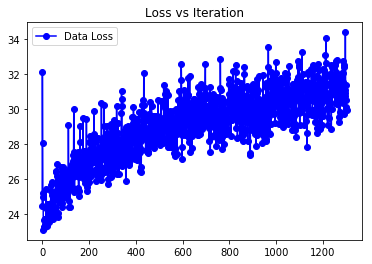

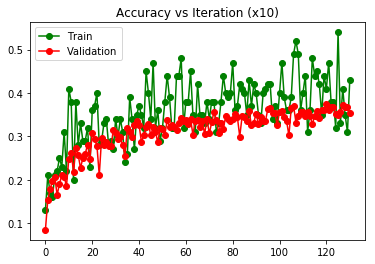

[5 0 8 8 8 1 5 8 6 7 8 7 3 1 1 9 8 7 3 5 8 8 9 7 8 9 2 1 1 1 5 9 5 8 7 5 8
 5 8 8 3 3 3 4 3 8 8 5 1 0 3 5 0 5 9 8 8 5 6 8 8 8 0 0 8 0 8 5 3 3 3 9 0 8
 9 5 8 6 8 8 3 8 1 3 8 0 8 1 9 9 2 9 8 8 8 5 6 0 1 8]
[ 9 10  2 12  1 14  4  5 33 10]
[5 1 5 ..., 5 3 6]
[ 554  499  230  434  121  756  221  361 1337  487]
cost: 32.07608599744641, train accuracy: 0.41, validation accuracy: 0.3258
iterations finished: 1311 alpha: 0.0008100000000000001 reg. lambda: 0.0


[6 3 5 6 6 9 0 5 6 8 0 7 6 9 8 1 8 4 6 6 4 4 2 4 6 0 9 5 9 8 1 9 6 6 9 6 8
 6 5 1 6 6 1 6 0 6 8 1 0 0 6 9 5 1 8 1 1 9 6 9 5 6 6 6 8 6 9 3 1 6 8 2 8 8
 5 6 6 9 0 0 8 7 1 9 1 2 9 6 6 7 1 0 6 4 3 0 6 8 1 9]
[10 13  3  3  5  7 29  3 13 14]
[6 1 6 ..., 5 6 6]
[ 386  650  183  216  286  365 1465  341  553  555]
cost: 30.4246956810535, train accuracy: 0.51, validation accuracy: 0.3504
iterations finished: 1321 alpha: 0.0008100000000000001 reg. lambda: 0.0


[4 4 6 3 3 8 2 1 0 6 8 8 6 4 4 3 0 3 0 6 0 2 9 3 1 6 6 8 0 2 6 9 8 9 1 4 4
 8 2 6 7 0 7 8

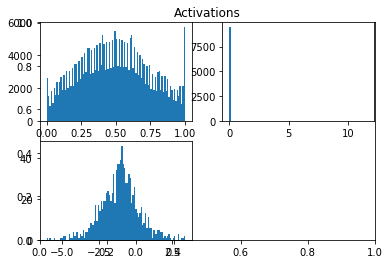

[4 2 8 2 5 9 8 8 4 9 8 7 3 1 1 4 4 8 2 4 8 6 1 7 4 0 7 2 4 9 2 0 8 8 4 7 8
 6 2 4 2 8 6 6 4 6 8 4 6 4 7 8 2 8 2 8 7 4 8 9 4 2 9 7 6 6 8 4 7 8 8 7 8 1
 2 8 5 0 8 0 7 0 9 8 7 9 2 5 4 8 9 9 2 4 2 2 9 5 4 8]
[ 5  4 15  1 18  4  8 11 24 10]
[6 1 6 ..., 5 2 4]
[ 355  309  443  110 1116  271  604  456  805  531]
cost: 29.97824634468472, train accuracy: 0.44, validation accuracy: 0.3622
iterations finished: 1401 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.0011346939846 SD 0.027060793331
Weights 1 Mean -0.00155329803455 SD 0.144972196944


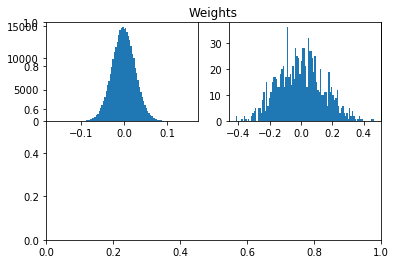

dW 0 Mean -0.0118222191599 SD 0.252420904334
dW 1 Mean 1.42108547152e-17 SD 2.44297871198


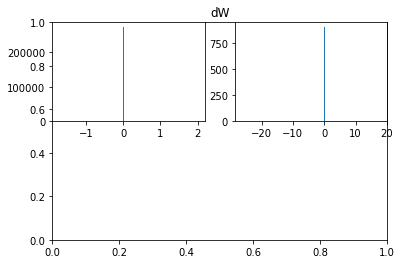

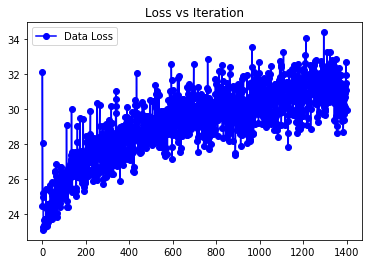

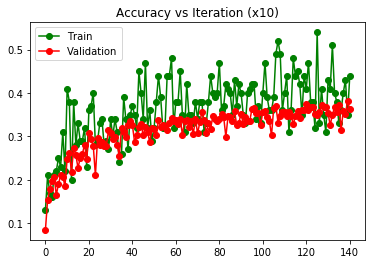

[1 3 3 7 6 6 5 1 3 4 9 0 5 7 9 1 9 7 6 4 6 8 5 9 2 9 4 9 6 1 7 3 1 6 7 6 4
 0 4 6 7 6 3 7 0 7 1 9 8 7 3 1 1 6 0 1 6 9 5 5 1 5 7 1 7 6 1 9 6 8 3 4 9 1
 6 7 0 9 6 5 6 5 9 0 0 7 1 9 9 6 0 9 9 9 4 1 9 7 2 9]
[ 8 15  2  7  7  8 17 14  3 19]
[6 1 7 ..., 5 6 6]
[ 474  801  170  305  379  386  731  512  183 1059]
cost: 30.785980648052288, train accuracy: 0.38, validation accuracy: 0.349
iterations finished: 1411 alpha: 0.0008100000000000001 reg. lambda: 0.0


[3 0 9 0 0 0 3 7 2 5 9 1 7 0 9 2 3 3 0 7 6 5 8 7 2 2 6 1 0 9 0 9 3 3 6 9 3
 9 3 8 8 3 1 5 2 3 6 7 1 7 8 3 8 7 9 7 0 9 3 9 8 1 5 5 0 6 3 0 9 2 0 7 0 7
 3 6 6 0 3 1 0 0 5 5 6 5 3 0 0 2 1 6 5 2 2 3 6 2 2 9]
[18  7 11 17  0  9 10 10  6 12]
[6 1 6 ..., 5 3 6]
[864 401 613 771  45 359 713 551 157 526]
cost: 29.77204024509236, train accuracy: 0.44, validation accuracy: 0.3622
iterations finished: 1421 alpha: 0.0008100000000000001 reg. lambda: 0.0


[9 2 0 4 6 3 9 6 4 5 5 6 0 5 6 0 0 0 3 0 9 6 7 7 5 6 2 0 4 4 0 5 6 0 4 6 7
 1 5 0 4 8 0 2 4 5 1 8 

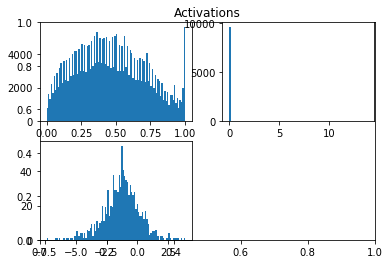

[9 3 3 3 4 8 3 1 7 5 7 0 9 7 9 3 7 9 3 1 6 6 0 7 7 4 5 6 1 0 1 7 2 2 0 9 5
 8 5 5 9 9 9 4 7 7 3 0 7 1 3 5 5 1 5 7 7 5 3 7 3 9 2 3 0 4 8 0 7 9 9 9 5 5
 0 5 8 9 9 9 2 6 2 4 4 4 9 0 5 1 9 3 5 4 8 5 7 7 5 4]
[ 9  7  5 12  9 16  4 16  5 17]
[5 1 5 ..., 5 3 6]
[ 333  426  130  332  297  801  590  572  401 1118]
cost: 31.061817610595767, train accuracy: 0.42, validation accuracy: 0.3564
iterations finished: 1501 alpha: 0.000729 reg. lambda: 0.0


Weights 0 Mean -0.00115777973558 SD 0.0271533888694
Weights 1 Mean -0.00155329803455 SD 0.14525616152


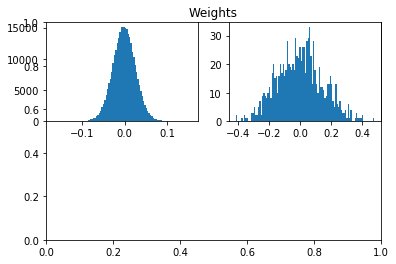

dW 0 Mean -0.0194143290387 SD 0.284920517292
dW 1 Mean 3.90798504668e-17 SD 2.67692340919


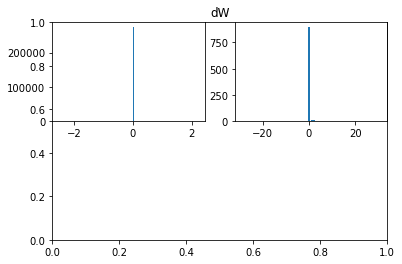

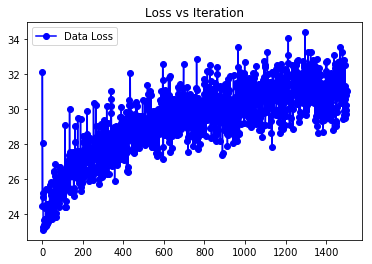

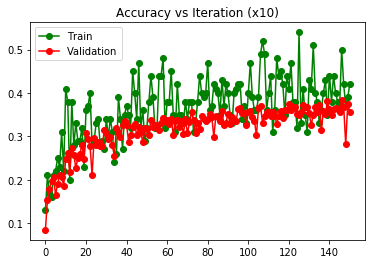

[6 8 0 6 3 7 0 7 9 7 2 7 3 1 0 0 1 0 1 4 4 9 0 3 9 4 9 9 0 7 2 1 4 0 6 4 5
 0 0 4 4 9 6 9 9 7 7 9 0 6 4 5 0 0 6 2 5 4 9 9 4 9 7 7 9 0 9 2 2 9 8 9 0 0
 0 0 2 7 2 4 9 3 0 5 6 8 6 7 0 5 7 4 8 9 5 8 7 0 7 8]
[21  4  7  4 12  6  8 14  6 18]
[5 1 6 ..., 5 2 6]
[683 327 344 309 554 344 479 780 421 759]
cost: 31.374474614188493, train accuracy: 0.37, validation accuracy: 0.3752
iterations finished: 1511 alpha: 0.000729 reg. lambda: 0.0


[9 4 8 7 1 7 0 6 2 5 1 1 1 4 1 6 9 9 1 1 9 6 5 1 3 7 5 5 9 1 3 1 9 8 6 3 4
 9 5 5 5 4 8 2 4 5 5 4 6 5 0 7 6 7 8 3 6 0 6 3 8 1 1 9 0 2 9 8 6 4 5 8 1 7
 0 5 1 9 3 9 5 1 0 6 9 9 6 7 3 0 3 1 6 5 3 9 7 9 3 9]
[ 7 16  3 10  7 14 12  8  7 16]
[5 1 6 ..., 5 3 6]
[450 540 259 667 322 377 718 494 557 616]
cost: 31.58932065775033, train accuracy: 0.39, validation accuracy: 0.3772
iterations finished: 1521 alpha: 0.000729 reg. lambda: 0.0


[3 0 7 0 8 0 8 6 3 7 0 4 0 2 4 0 6 8 3 6 4 0 0 6 0 1 9 9 3 9 4 0 1 6 1 1 9
 3 1 4 4 7 1 4 8 6 9 8 1 9 3 8 3 6 1 5 4 8 9 0 3 9 1 6 7 1

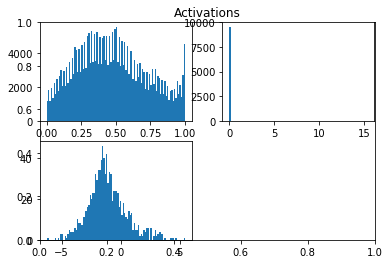

[7 7 1 5 6 1 6 6 8 5 6 4 9 9 8 5 1 7 2 0 2 2 7 0 1 0 7 8 5 6 1 4 2 5 4 8 7
 8 6 8 8 7 1 8 3 2 0 0 9 5 1 4 8 8 0 9 8 2 5 1 6 5 1 5 1 5 5 6 8 1 5 1 7 7
 8 7 6 9 7 5 1 0 5 5 7 0 1 3 5 5 5 1 5 4 1 1 0 8 9 3]
[ 9 17  6  3  5 19  9 12 14  6]
[5 1 6 ..., 5 5 6]
[546 714 458 130 169 684 523 701 752 323]
cost: 33.46833474959649, train accuracy: 0.46, validation accuracy: 0.3786
iterations finished: 1601 alpha: 0.000729 reg. lambda: 0.0


Weights 0 Mean -0.00113417051837 SD 0.0272080943278
Weights 1 Mean -0.00155329803455 SD 0.14550605323


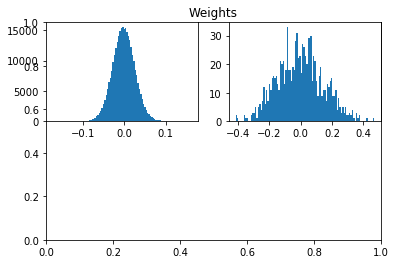

dW 0 Mean 0.00329592884177 SD 0.220452339082
dW 1 Mean 7.1054273576e-18 SD 2.52845524041


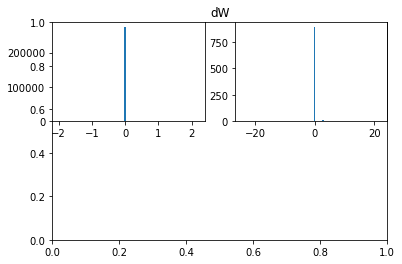

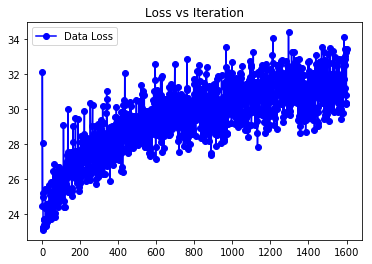

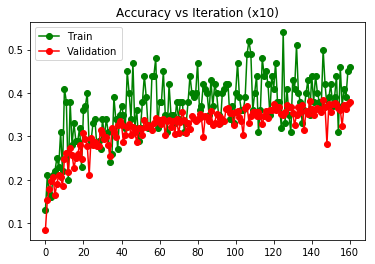

[8 8 4 7 3 7 6 8 3 7 6 7 3 6 5 3 2 8 3 8 5 1 2 0 3 6 0 8 4 0 6 1 5 3 9 4 4
 2 2 8 6 0 7 0 0 2 3 9 0 6 6 3 0 3 1 6 4 6 1 1 7 3 7 8 0 0 6 7 3 1 0 6 2 8
 7 7 3 3 9 7 6 6 8 1 3 2 1 7 1 0 3 0 9 6 0 3 9 8 9 7]
[14  9  7 17  5  3 15 13 11  6]
[6 1 6 ..., 5 3 6]
[529 434 612 591 159 305 864 571 521 414]
cost: 30.018972282953847, train accuracy: 0.27, validation accuracy: 0.3786
iterations finished: 1611 alpha: 0.000729 reg. lambda: 0.0


[2 6 2 0 4 7 2 4 0 6 3 6 2 6 8 0 7 9 7 9 0 9 7 6 2 9 5 7 8 6 0 9 3 3 0 0 0
 3 9 2 7 3 5 9 6 7 8 0 1 3 0 2 9 9 3 6 3 3 9 4 4 8 7 8 0 9 3 0 7 9 2 5 8 6
 0 7 7 8 3 6 6 5 6 1 4 0 5 2 6 3 5 6 1 6 1 8 7 7 3 3]
[14  4  9 14  5  6 15 13  8 12]
[6 7 6 ..., 5 3 6]
[ 685  321  362  619  461  245 1021  559  333  394]
cost: 31.623469625300814, train accuracy: 0.46, validation accuracy: 0.3742
iterations finished: 1621 alpha: 0.000729 reg. lambda: 0.0


[4 3 5 3 8 3 9 0 8 4 0 1 5 3 3 0 0 6 5 8 4 9 3 0 6 2 2 1 9 9 5 6 0 7 0 9 5
 6 6 0 1 4 2 6 4 9 0 7 4 6 8 9 3 4 5 0 3 8 8 4 

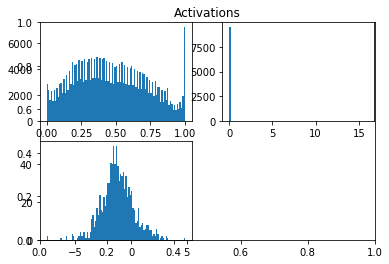

[0 4 4 9 8 3 4 6 1 8 6 0 6 2 4 1 7 7 6 4 4 6 4 7 1 1 1 9 7 0 9 9 1 0 6 9 5
 3 8 9 6 9 1 1 9 6 9 6 7 3 9 1 9 1 6 7 9 2 6 7 0 1 4 4 6 7 4 9 4 7 4 1 9 4
 7 7 9 0 5 8 8 0 3 8 9 6 9 9 4 3 4 6 3 8 5 7 9 9 0 7]
[ 8 12  2  6 15  3 14 13  7 20]
[6 1 6 ..., 3 6 6]
[488 559  90 575 858  88 569 737 265 771]
cost: 31.44504372983166, train accuracy: 0.44, validation accuracy: 0.3714
iterations finished: 1701 alpha: 0.000729 reg. lambda: 0.0


Weights 0 Mean -0.00112493955314 SD 0.027269256291
Weights 1 Mean -0.00155329803455 SD 0.145840119828


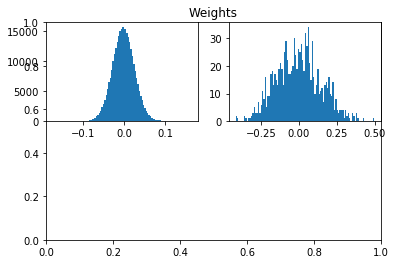

dW 0 Mean -0.000825356237108 SD 0.305069832694
dW 1 Mean -2.84217094304e-17 SD 3.31543657705


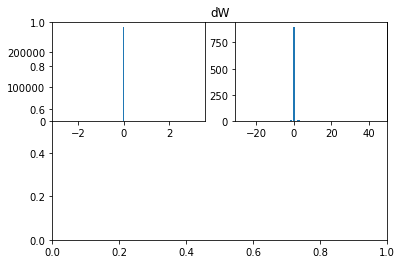

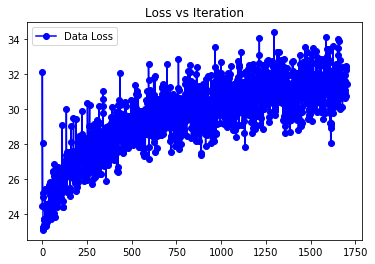

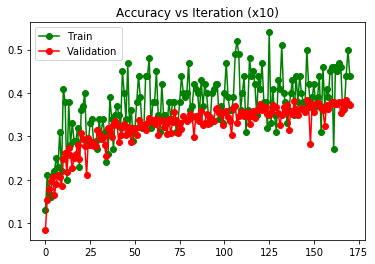

[5 6 3 9 2 2 6 8 6 5 3 2 6 3 9 8 5 0 0 0 8 5 8 6 2 5 8 0 6 5 3 6 6 7 2 2 3
 2 6 2 2 2 1 5 1 5 6 6 8 5 6 6 6 6 5 5 5 1 8 5 5 5 1 6 6 5 2 8 6 8 2 0 2 0
 2 6 9 7 9 8 8 6 3 9 3 6 8 2 2 3 8 1 3 5 5 5 5 5 5 3]
[ 6  5 16 10  0 22 21  2 13  5]
[6 9 6 ..., 5 5 6]
[ 188  237  809  268    5 1125 1059  131  722  456]
cost: 35.00612629234892, train accuracy: 0.41, validation accuracy: 0.322
iterations finished: 1711 alpha: 0.000729 reg. lambda: 0.0


[6 4 8 9 5 2 5 0 6 8 6 5 5 4 0 6 7 0 7 7 3 8 0 7 3 0 0 6 7 4 8 8 7 0 9 6 6
 2 5 7 3 5 9 3 8 1 0 0 3 8 7 3 5 3 3 1 9 6 6 3 7 8 9 7 0 4 0 3 5 3 7 8 3 3
 7 5 7 8 8 6 8 4 6 5 3 0 9 8 5 6 1 1 9 3 5 1 7 0 2 1]
[13  6  3 15  5 12 12 14 13  7]
[3 1 7 ..., 5 3 6]
[476 475 143 561 184 545 688 853 587 488]
cost: 31.744300365180912, train accuracy: 0.3, validation accuracy: 0.3864
iterations finished: 1721 alpha: 0.000729 reg. lambda: 0.0


[3 9 7 5 7 8 6 6 7 8 5 6 8 3 3 3 5 3 3 7 8 5 7 4 8 6 8 6 8 5 7 3 7 8 8 5 6
 2 5 3 6 6 8 5 1 1 5 1 6 9 8 6 6 7 3 8 5 8 9 5 0 7

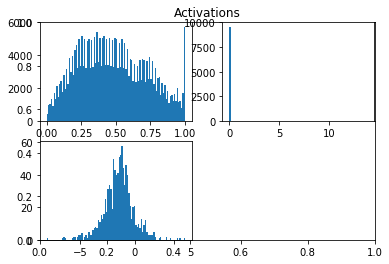

[9 2 5 5 8 9 2 5 0 1 5 6 5 1 7 8 2 9 6 8 5 7 6 0 1 1 2 2 0 0 2 2 6 4 5 7 6
 9 6 9 0 8 6 2 6 8 9 6 1 2 7 2 6 8 6 6 7 9 2 2 6 7 1 0 5 8 9 2 9 1 9 2 2 0
 7 0 6 8 7 4 2 5 0 1 0 9 1 1 6 2 5 5 0 6 1 0 7 0 2 7]
[13 11 18  0  2 11 16 10  8 11]
[6 9 6 ..., 5 2 6]
[594 515 643  30 277 683 754 555 249 700]
cost: 30.46015527352548, train accuracy: 0.52, validation accuracy: 0.3826
iterations finished: 1801 alpha: 0.000729 reg. lambda: 0.0


Weights 0 Mean -0.00113711468822 SD 0.0273289147035
Weights 1 Mean -0.00155329803455 SD 0.146033489756


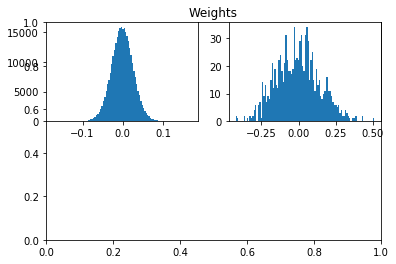

dW 0 Mean -0.00779704360036 SD 0.224636001868
dW 1 Mean 7.1054273576e-18 SD 2.5630198585


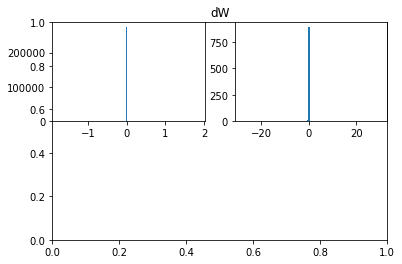

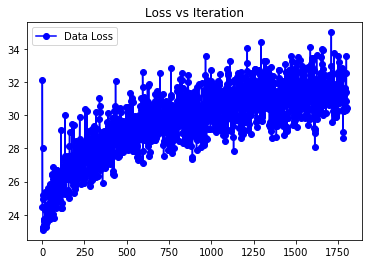

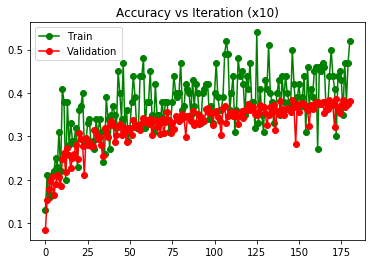

[2 6 8 3 7 8 6 5 6 5 1 9 4 6 6 9 8 8 3 6 8 5 9 7 3 8 9 3 9 8 8 1 5 9 6 6 5
 8 8 5 1 6 6 7 8 5 6 6 7 5 4 5 6 9 9 0 4 6 9 9 6 2 4 2 5 6 2 6 9 4 9 5 3 9
 6 1 6 9 6 2 5 7 4 8 8 8 3 0 6 9 8 3 8 6 5 7 6 3 6 3]
[ 2  4  5  9  6 13 24  6 16 15]
[6 9 6 ..., 5 6 6]
[ 134  425  100  529  187  495 1259  464  720  687]
cost: 31.8761491181762, train accuracy: 0.46, validation accuracy: 0.3592
iterations finished: 1811 alpha: 0.000729 reg. lambda: 0.0


[4 9 4 0 4 0 3 4 7 7 9 9 2 0 9 0 2 9 0 3 1 1 0 2 6 4 9 7 5 9 6 7 9 7 5 9 4
 7 2 7 1 0 9 7 9 1 9 0 7 1 4 6 9 0 6 3 0 7 4 1 4 9 9 8 4 2 7 7 9 3 6 0 3 7
 2 9 0 6 2 5 6 1 6 6 1 1 9 6 4 2 2 5 6 4 7 7 0 6 0 4]
[14  9  9  5 13  4 12 15  1 18]
[6 1 6 ..., 5 2 6]
[ 782  517  414  165  764  169  636  435   85 1033]
cost: 31.00372471399969, train accuracy: 0.56, validation accuracy: 0.3524
iterations finished: 1821 alpha: 0.000729 reg. lambda: 0.0


[6 0 6 8 5 4 9 4 5 8 2 7 7 1 8 5 3 2 7 6 6 7 7 2 9 9 5 5 5 8 6 6 8 0 0 5 0
 1 5 7 0 7 6 5 2 7 5 9 6 9 0 0 0 2 0 6 5

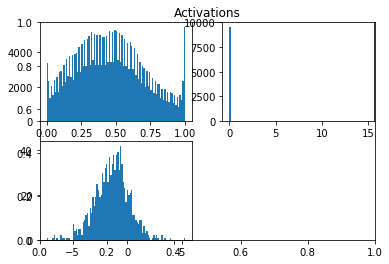

[3 4 6 7 0 3 8 6 5 7 9 2 5 9 9 8 6 6 7 2 9 6 3 6 1 3 2 0 6 8 7 9 2 9 5 6 6
 7 0 0 7 6 6 6 8 9 5 9 3 7 8 6 9 3 6 4 5 3 2 2 3 3 7 6 7 5 8 3 2 6 1 7 6 8
 0 6 3 8 6 7 1 9 7 6 7 9 8 6 3 6 6 4 7 6 7 0 8 7 7 6]
[ 6  3  7 12  3  6 25 17 10 11]
[6 9 6 ..., 5 6 6]
[396 188 313 695 332 258 998 578 651 591]
cost: 31.949251461346968, train accuracy: 0.52, validation accuracy: 0.3782
iterations finished: 1901 alpha: 0.000729 reg. lambda: 0.0


Weights 0 Mean -0.00110456902619 SD 0.0274028789546
Weights 1 Mean -0.00155329803455 SD 0.146464844805


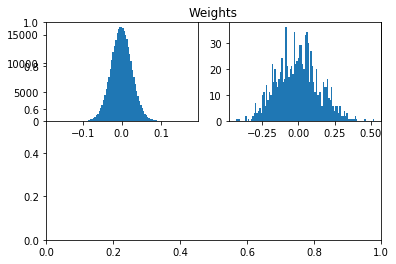

dW 0 Mean -0.0250828507026 SD 0.266061686844
dW 1 Mean -2.84217094304e-17 SD 2.92474968803


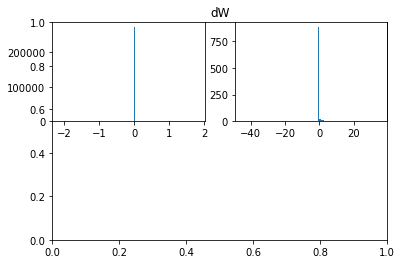

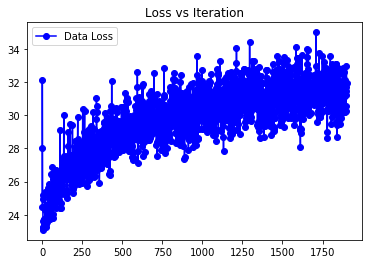

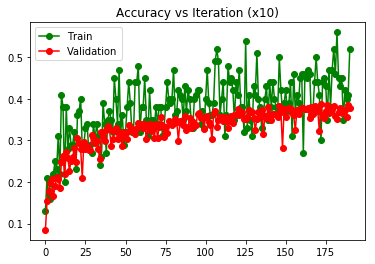

[0 0 3 0 8 9 8 8 3 6 9 2 2 2 3 0 4 6 4 8 2 0 0 6 1 2 7 6 4 2 4 0 7 8 0 8 8
 9 9 8 7 8 6 1 2 0 4 8 0 8 5 6 1 6 3 9 0 8 2 3 3 1 0 9 2 6 8 0 9 8 6 2 3 3
 3 6 2 2 5 4 6 8 9 3 6 6 6 4 8 3 6 5 4 0 3 2 8 8 8 8]
[14  4 13 12  8  3 15  3 20  8]
[6 1 6 ..., 5 3 6]
[483 323 678 569 426 277 824 286 732 402]
cost: 31.660895773910635, train accuracy: 0.46, validation accuracy: 0.38
iterations finished: 1911 alpha: 0.000729 reg. lambda: 0.0


[8 5 1 1 4 5 4 5 5 1 0 2 1 9 0 7 6 5 0 4 0 0 7 6 0 6 0 4 4 2 1 8 6 0 7 1 5
 4 1 6 4 1 2 0 0 8 2 0 5 6 4 0 6 6 8 0 1 1 9 5 1 0 1 8 1 1 0 2 6 0 8 9 8 4
 6 2 6 6 0 3 5 7 1 2 0 6 5 3 4 8 7 3 0 0 6 6 8 6 6 1]
[20 16  7  3 10 10 17  5  9  3]
[6 1 6 ..., 5 3 6]
[ 738 1028  280  427  400  383 1038  264  266  176]
cost: 32.808235068077565, train accuracy: 0.46, validation accuracy: 0.3644
iterations finished: 1921 alpha: 0.000729 reg. lambda: 0.0


[0 3 1 5 9 6 6 3 3 1 1 0 0 1 5 4 3 3 1 0 3 5 8 4 4 1 5 9 5 3 0 3 6 9 3 4 6
 1 8 4 4 0 9 3 9 7 4 9 1 8 8 3 1 6 3 2 1 8 9 6 6 

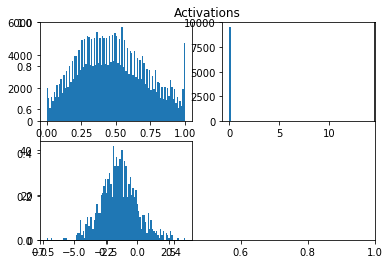

[7 9 9 9 9 5 2 6 6 7 2 2 7 1 9 0 7 3 0 9 0 7 6 2 9 8 3 7 6 9 9 3 7 2 3 8 0
 1 2 3 0 6 0 3 1 3 3 9 2 3 9 3 5 9 2 5 7 7 0 6 9 0 6 0 7 6 2 9 7 7 9 4 6 8
 5 1 7 6 7 0 3 2 0 7 9 0 0 9 3 7 6 3 4 7 4 3 4 0 9 6]
[14  4 10 14  4  4 12 17  3 18]
[6 1 2 ..., 5 3 6]
[629 289 618 654 296 269 496 577 315 857]
cost: 31.43854971529781, train accuracy: 0.44, validation accuracy: 0.3804
iterations finished: 2001 alpha: 0.0006561000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00111499043726 SD 0.0274557769603
Weights 1 Mean -0.00155329803455 SD 0.145944927997


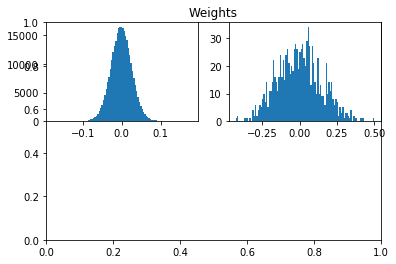

dW 0 Mean -0.0159047640179 SD 0.276330424096
dW 1 Mean 3.5527136788e-17 SD 2.8758749183


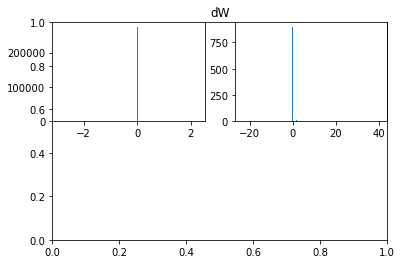

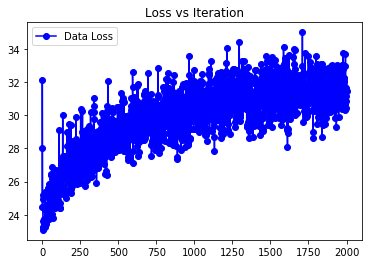

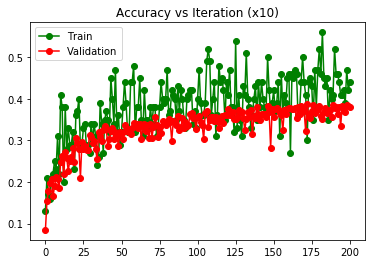

[4 6 7 7 0 9 8 1 6 0 7 0 7 5 8 1 0 6 7 5 2 4 0 4 7 9 4 0 3 1 5 0 7 0 8 1 6
 1 9 1 9 4 3 7 6 2 5 5 7 6 5 6 7 1 9 9 0 0 5 5 2 1 1 9 5 1 6 6 5 6 8 7 9 9
 2 6 8 0 6 0 1 5 5 7 0 6 5 5 1 7 5 8 7 9 5 8 0 6 9 6]
[14 12  4  2  5 16 15 14  7 11]
[6 1 6 ..., 5 3 6]
[671 643 110 152 340 691 659 503 600 631]
cost: 31.110417621322586, train accuracy: 0.41, validation accuracy: 0.3818
iterations finished: 2011 alpha: 0.0006561000000000001 reg. lambda: 0.0


[2 0 5 6 7 9 9 0 4 7 3 5 5 6 7 4 1 0 7 1 4 3 6 7 9 3 7 6 2 8 6 5 8 4 3 9 6
 0 8 8 4 9 6 0 7 0 2 7 8 8 8 8 7 8 8 7 4 0 7 7 7 8 6 6 7 4 6 2 9 8 0 1 8 9
 6 8 3 4 8 8 0 8 0 8 6 3 1 6 8 7 9 0 2 9 3 9 6 1 3 0]
[12  5  5  8  8  4 14 15 19 10]
[6 1 6 ..., 5 3 6]
[517 428 259 258 347 571 651 701 758 510]
cost: 30.598425709452446, train accuracy: 0.4, validation accuracy: 0.3952
iterations finished: 2021 alpha: 0.0006561000000000001 reg. lambda: 0.0


[3 0 5 8 4 2 1 2 8 8 0 9 6 8 4 1 6 4 8 8 4 4 5 3 8 5 6 6 8 7 4 2 5 5 5 8 4
 2 4 1 1 9 4 7 4 5 8 8 1 2 6 2 7

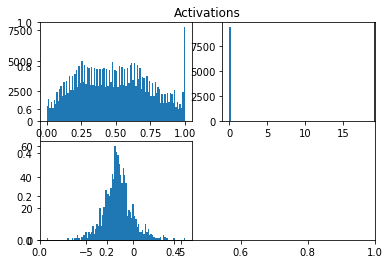

[2 4 5 4 2 6 3 4 0 6 2 4 1 6 0 1 0 0 0 8 8 0 0 6 3 9 6 5 2 8 6 4 4 8 6 1 4
 7 0 6 2 0 5 8 4 6 0 2 1 8 8 0 6 6 6 1 2 4 3 0 8 6 4 0 3 4 8 5 4 8 3 4 0 0
 4 1 0 1 1 0 1 6 8 6 6 2 5 6 6 4 1 6 4 0 6 2 1 0 6 6]
[19 11  9  5 16  5 22  1 11  1]
[6 1 2 ..., 5 2 6]
[ 951  493  643  260  509  284 1025  135  461  239]
cost: 32.469540775818686, train accuracy: 0.42, validation accuracy: 0.3554
iterations finished: 2101 alpha: 0.0006561000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00112805552486 SD 0.0275077914272
Weights 1 Mean -0.00155329803455 SD 0.146300391509


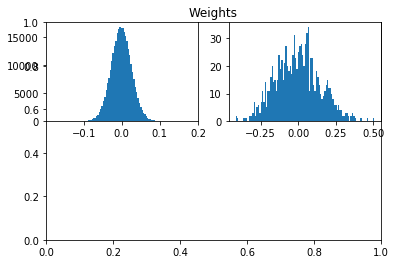

dW 0 Mean 0.054385708256 SD 0.515056518786
dW 1 Mean 2.84217094304e-17 SD 3.63739273579


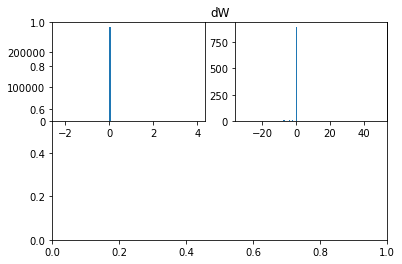

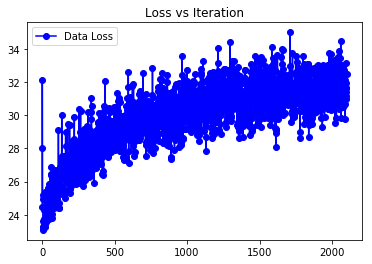

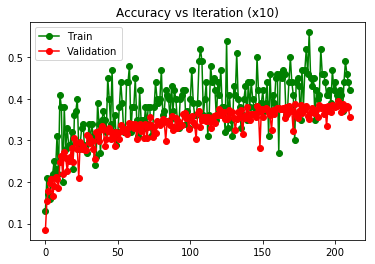

[0 0 8 1 0 6 8 8 0 9 4 1 0 6 9 5 9 5 2 0 1 4 7 7 7 5 6 5 0 0 0 9 6 6 0 0 0
 2 0 7 7 0 6 1 7 3 6 9 7 5 0 7 8 2 2 5 4 9 6 5 9 8 8 1 6 5 5 0 6 9 0 0 8 0
 0 6 0 7 7 3 0 0 6 6 6 0 9 0 6 3 6 7 2 1 4 5 8 6 3 9]
[25  6  5  4  4 10 17 11  8 10]
[6 1 6 ..., 5 6 6]
[932 473 382 277 246 401 923 518 390 458]
cost: 31.91614027241977, train accuracy: 0.37, validation accuracy: 0.3846
iterations finished: 2111 alpha: 0.0006561000000000001 reg. lambda: 0.0


[4 9 4 0 9 4 2 4 1 6 7 5 5 4 9 8 2 8 6 7 0 1 7 9 1 7 7 5 0 8 5 5 4 8 1 7 5
 9 0 0 5 0 0 9 5 5 5 1 8 7 0 0 3 5 1 9 0 9 9 0 8 5 3 2 8 0 9 1 1 6 5 4 5 8
 4 5 8 1 0 0 4 0 0 5 0 8 0 9 7 9 0 4 8 4 8 0 1 5 0 1]
[21 11  3  2 11 17  3  8 12 12]
[5 1 2 ..., 5 5 6]
[683 522 235 132 512 772 536 478 472 658]
cost: 32.03789343264213, train accuracy: 0.42, validation accuracy: 0.3856
iterations finished: 2121 alpha: 0.0006561000000000001 reg. lambda: 0.0


[8 4 6 0 1 4 7 8 7 2 8 4 7 8 5 8 6 9 7 8 6 3 3 1 8 9 6 1 9 6 0 1 0 1 5 3 8
 8 5 7 0 2 8 7 8 1 1 8 7 8 9 8 3 

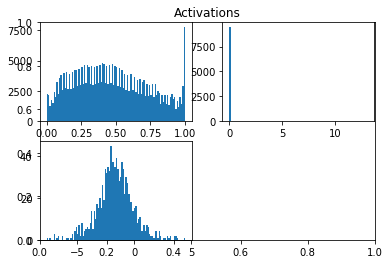

[9 1 1 1 4 4 8 5 1 5 3 1 7 1 1 1 4 1 0 5 8 7 7 4 1 1 1 1 5 5 6 1 7 9 1 9 7
 5 1 8 0 4 4 0 7 5 6 4 0 1 0 3 2 1 1 1 9 7 1 5 1 6 5 1 5 0 4 0 5 1 0 1 0 8
 7 1 0 9 2 1 1 1 5 4 7 0 4 4 5 6 6 9 6 7 1 1 9 0 1 1]
[12 33  2  2 11 13  6 10  4  7]
[5 1 6 ..., 5 1 4]
[ 634 1489  266  145  488  599  459  450  265  205]
cost: 32.827454817167805, train accuracy: 0.42, validation accuracy: 0.3594
iterations finished: 2201 alpha: 0.0006561000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00109206404484 SD 0.0275574497468
Weights 1 Mean -0.00155329803455 SD 0.146851738623


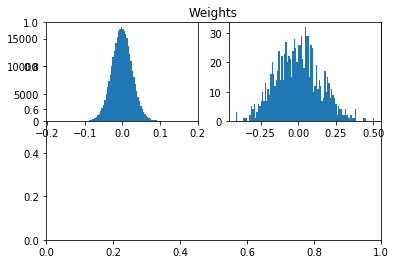

dW 0 Mean -0.00250947007696 SD 0.302799907253
dW 1 Mean 4.26325641456e-17 SD 2.74491684483


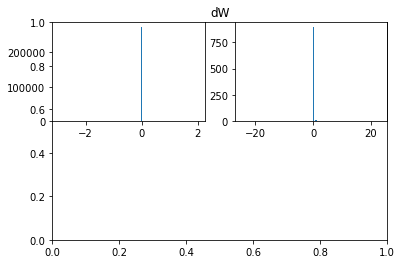

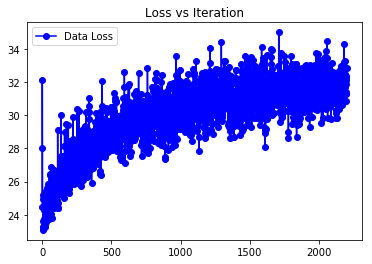

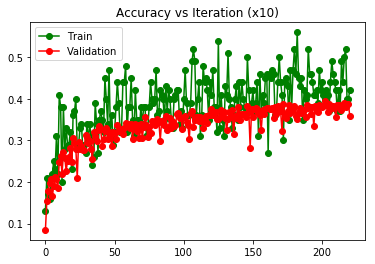

[2 0 7 5 8 4 0 4 7 7 0 8 7 2 3 4 4 1 3 4 4 3 5 8 0 4 0 7 0 4 6 6 2 1 5 4 7
 3 0 3 4 6 0 6 4 4 6 4 3 1 6 7 3 3 4 3 0 2 3 3 8 6 5 4 7 7 3 7 2 6 3 2 8 9
 7 9 4 0 3 4 1 2 3 3 0 3 3 2 3 8 8 0 4 4 0 4 0 1 4 3]
[14  5  8 20 21  4  8 11  7  2]
[4 1 6 ..., 5 3 4]
[580 303 532 882 803 186 487 595 398 234]
cost: 33.472514322335876, train accuracy: 0.35, validation accuracy: 0.3634
iterations finished: 2211 alpha: 0.0006561000000000001 reg. lambda: 0.0


[6 5 9 0 2 1 7 6 9 4 9 9 4 4 7 9 1 1 6 0 8 8 3 6 1 9 4 1 7 6 4 0 2 1 7 7 8
 3 0 4 9 8 6 9 8 4 1 4 1 3 9 0 1 7 7 6 1 6 4 0 6 4 5 5 9 5 9 7 4 6 7 7 4 7
 8 4 8 5 9 1 9 0 6 9 5 1 4 8 9 5 6 2 9 4 7 8 8 4 4 0]
[ 8 12  3  3 17  7 12 12 10 16]
[6 1 6 ..., 5 6 4]
[316 563 136  24 822 570 599 681 452 837]
cost: 32.60621272697422, train accuracy: 0.46, validation accuracy: 0.3748
iterations finished: 2221 alpha: 0.0006561000000000001 reg. lambda: 0.0


[7 9 3 5 0 3 1 5 2 5 9 9 1 0 3 8 8 8 2 4 6 0 9 9 5 9 7 2 6 0 8 5 0 5 6 7 2
 4 5 0 8 5 3 7 1 5 5 8 0 5 3 7 7

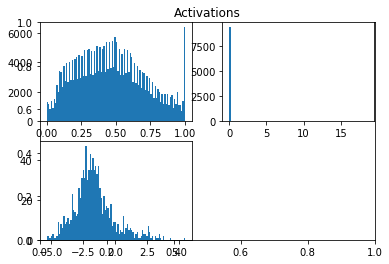

[5 7 9 8 4 2 9 1 9 3 7 5 7 7 5 3 8 0 5 2 8 2 3 8 8 8 7 2 7 5 0 0 9 6 9 9 3
 0 8 2 6 6 3 9 9 7 3 6 4 2 3 9 6 7 8 8 8 9 8 7 5 9 6 6 5 2 9 9 2 7 4 9 7 9
 9 8 9 3 9 8 2 5 5 6 6 9 2 9 8 1 8 6 8 6 3 3 5 5 2 5]
[ 4  2 11 10  3 12 11 11 16 20]
[5 9 6 ..., 5 3 6]
[385 181 507 439 149 635 718 506 728 752]
cost: 33.4580975233501, train accuracy: 0.35, validation accuracy: 0.378
iterations finished: 2301 alpha: 0.0006561000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00109289822723 SD 0.0276071196981
Weights 1 Mean -0.00155329803455 SD 0.147131229616


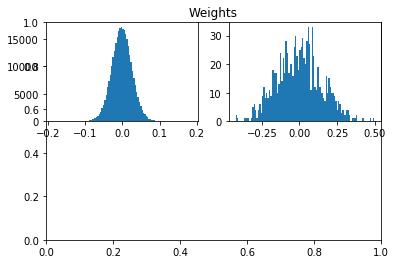

dW 0 Mean 0.0467725708891 SD 0.483878316236
dW 1 Mean -3.5527136788e-17 SD 3.06725144799


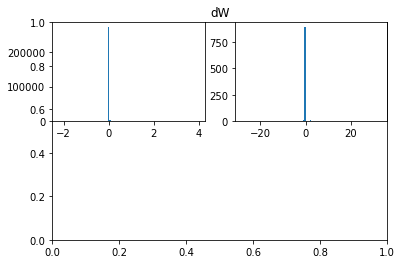

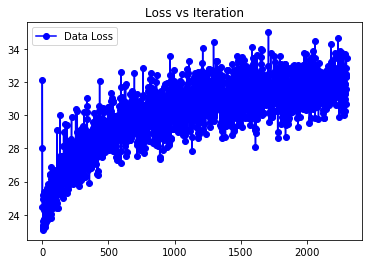

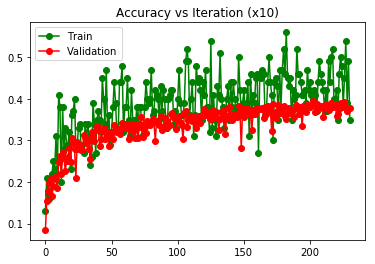

[0 7 4 8 8 5 8 5 4 8 5 6 5 4 5 1 9 8 1 1 2 1 7 3 8 1 8 6 1 8 4 8 5 1 8 7 5
 4 6 3 7 8 1 4 7 2 6 8 3 8 6 8 5 7 2 3 8 9 8 6 0 3 7 0 4 8 1 9 8 6 4 5 0 3
 7 5 4 8 1 6 9 4 6 5 4 2 6 0 6 6 6 4 1 8 0 4 9 7 5 9]
[ 6 11  4  6 13 12 13  9 20  6]
[6 1 6 ..., 5 6 4]
[311 566 290 279 537 503 790 402 887 435]
cost: 30.7103338613554, train accuracy: 0.38, validation accuracy: 0.3868
iterations finished: 2311 alpha: 0.0006561000000000001 reg. lambda: 0.0


[6 2 2 5 1 3 1 1 1 4 1 0 8 1 4 3 2 9 9 1 0 2 0 8 6 4 5 0 2 6 9 6 6 7 2 5 1
 4 0 6 9 6 6 1 0 8 0 1 2 3 2 3 2 6 5 7 6 8 2 5 4 4 9 6 9 3 1 0 3 7 8 1 1 8
 5 2 9 1 7 7 7 6 1 8 4 8 1 4 7 9 5 9 3 8 1 3 5 9 4 3]
[ 8 17 11  9  9  8 12  7  9 10]
[3 1 6 ..., 5 3 4]
[362 686 606 456 480 442 487 413 485 583]
cost: 31.91434289396892, train accuracy: 0.47, validation accuracy: 0.3884
iterations finished: 2321 alpha: 0.0006561000000000001 reg. lambda: 0.0


[1 0 6 4 7 7 8 8 0 3 7 7 3 9 1 5 0 4 6 7 1 8 8 0 3 7 4 4 1 9 4 1 3 9 0 3 7
 0 9 8 8 0 1 8 0 9 4 0 8 4 5 3 1 3

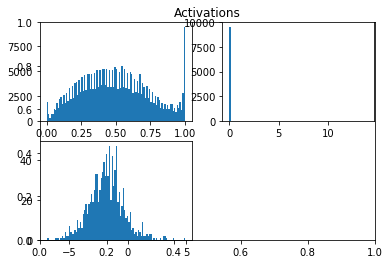

[0 2 8 5 6 9 7 5 8 3 3 6 5 6 2 6 5 0 0 5 8 1 9 1 0 6 5 6 8 2 1 6 6 5 5 2 4
 1 6 8 9 2 8 1 9 5 5 9 3 5 5 8 0 6 3 5 8 5 9 8 9 9 7 8 8 0 4 9 6 5 9 4 8 8
 9 6 4 4 6 0 6 4 5 5 5 5 9 4 6 5 2 7 0 5 6 6 1 3 4 8]
[ 8  6  6  5  8 21 17  3 14 12]
[6 1 6 ..., 5 3 6]
[ 377  354  319  225  334 1000  799  323  831  438]
cost: 31.559901579161593, train accuracy: 0.45, validation accuracy: 0.3822
iterations finished: 2401 alpha: 0.0006561000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00109037026013 SD 0.0276625698261
Weights 1 Mean -0.00155329803455 SD 0.146911820652


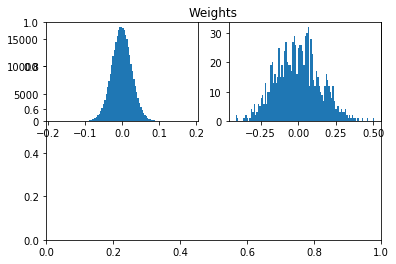

dW 0 Mean -0.000710674131612 SD 0.266296515806
dW 1 Mean 4.26325641456e-17 SD 2.89038282448


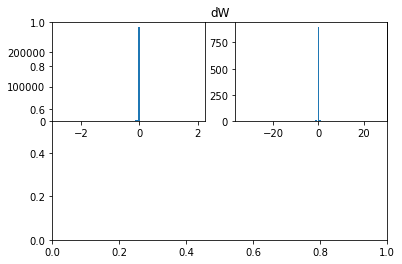

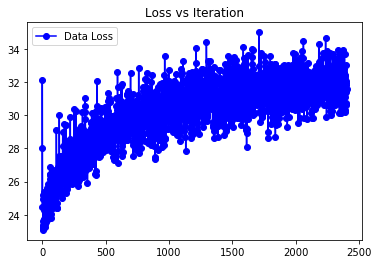

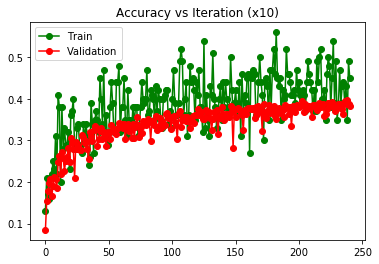

[6 3 6 4 6 6 4 5 2 8 6 3 3 4 2 6 1 5 1 6 1 8 1 0 6 8 8 1 2 6 5 0 6 8 7 8 1
 6 4 3 3 5 5 6 5 0 1 6 6 6 2 3 1 5 4 3 1 6 0 6 4 3 8 2 4 9 8 5 1 6 0 0 6 9
 3 3 9 1 6 6 5 0 4 8 1 6 0 7 1 5 8 6 6 9 6 9 3 6 2 2]
[ 8 13  7 11  8 10 26  2 10  5]
[6 1 6 ..., 5 3 6]
[474 684 353 408 597 357 842 271 609 405]
cost: 31.386771470929695, train accuracy: 0.4, validation accuracy: 0.3874
iterations finished: 2411 alpha: 0.0006561000000000001 reg. lambda: 0.0


[7 5 5 8 3 3 2 2 8 5 8 2 7 5 2 2 7 8 4 2 2 0 2 8 7 8 0 5 7 0 2 8 8 0 0 3 9
 8 6 7 4 8 5 0 7 7 5 8 4 7 8 8 3 0 5 8 5 8 6 0 4 9 8 8 8 5 5 8 8 6 2 6 8 9
 9 8 2 9 8 8 8 2 8 2 7 8 8 5 3 6 7 8 3 8 3 9 8 8 2 5]
[ 8  0 14  7  4 13  5 11 32  6]
[3 8 6 ..., 5 3 6]
[329 160 960 410 218 624 521 616 894 268]
cost: 32.25027653903757, train accuracy: 0.36, validation accuracy: 0.3646
iterations finished: 2421 alpha: 0.0006561000000000001 reg. lambda: 0.0


[7 3 3 6 5 3 3 2 7 2 8 7 9 4 2 5 9 8 9 7 2 6 8 6 0 9 1 8 4 2 1 0 5 0 8 4 8
 3 6 5 8 0 6 6 7 7 0 3 5 8 8 7 6 

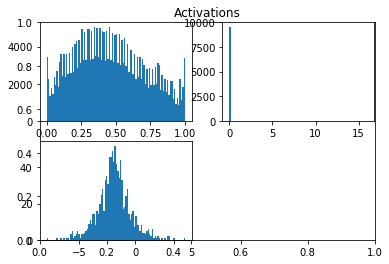

[3 3 7 4 3 1 4 0 4 4 6 3 7 4 0 0 9 5 9 3 7 5 8 6 4 3 7 0 7 7 4 4 5 4 5 4 4
 3 6 3 7 8 0 4 7 6 1 7 3 9 1 3 6 0 8 7 9 9 1 0 4 1 7 9 1 5 7 7 9 7 5 3 2 4
 6 7 4 9 9 3 0 0 1 7 8 1 3 6 1 0 8 0 3 3 2 7 0 6 3 7]
[12  9  2 16 15  6  8 18  5  9]
[3 1 6 ..., 5 3 6]
[658 322 159 712 640 293 431 789 423 573]
cost: 31.231339650501194, train accuracy: 0.5, validation accuracy: 0.3902
iterations finished: 2501 alpha: 0.00059049 reg. lambda: 0.0


Weights 0 Mean -0.00107746022291 SD 0.0277235752072
Weights 1 Mean -0.00155329803455 SD 0.147358839337


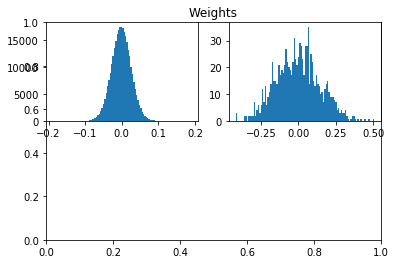

dW 0 Mean -0.0106894641626 SD 0.217642412987
dW 1 Mean -2.84217094304e-17 SD 2.73730834126


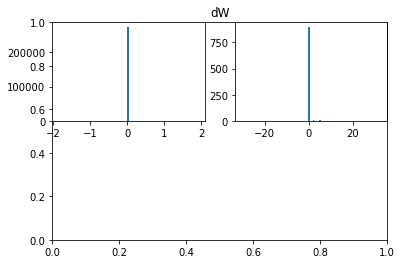

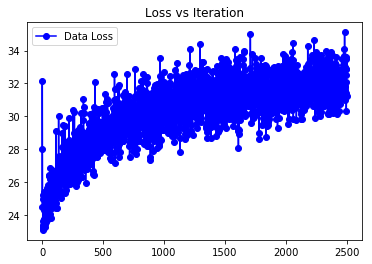

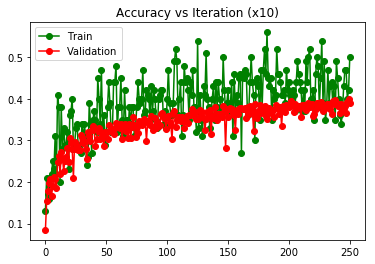

[1 4 6 4 8 9 5 5 0 7 5 1 9 5 1 5 1 1 4 4 4 8 9 4 5 7 7 2 9 0 5 0 5 5 4 0 4
 9 5 4 8 5 1 0 0 7 4 0 5 4 7 5 0 4 6 9 4 9 5 1 0 9 9 9 0 0 0 8 3 9 7 9 4 0
 5 5 4 5 1 7 0 8 7 0 0 5 8 0 0 5 4 5 1 9 3 4 1 5 1 9]
[18 11  1  2 17 21  2  8  6 14]
[5 1 2 ..., 5 0 4]
[888 593 163  86 693 709 321 598 397 552]
cost: 32.26910825829496, train accuracy: 0.41, validation accuracy: 0.3838
iterations finished: 2511 alpha: 0.00059049 reg. lambda: 0.0


[8 1 2 3 6 7 6 6 7 4 0 6 4 6 5 1 8 9 6 6 7 7 1 8 4 1 7 9 9 1 0 5 3 0 1 6 9
 6 1 1 3 6 6 0 7 6 6 0 9 6 1 6 6 0 8 0 6 6 3 6 1 3 8 3 0 6 8 8 6 8 6 8 2 6
 6 5 4 2 1 2 6 8 8 9 1 0 0 1 5 8 9 1 3 3 6 4 6 7 5 8]
[10 14  4  8  5  5 27  7 13  7]
[6 1 6 ..., 5 6 6]
[ 644  534  188  261  311  432 1086  514  678  352]
cost: 32.02611419251131, train accuracy: 0.48, validation accuracy: 0.3944
iterations finished: 2521 alpha: 0.00059049 reg. lambda: 0.0


[5 8 6 6 6 7 1 1 7 9 4 2 6 6 0 1 7 0 1 4 4 4 9 8 9 7 0 8 9 2 1 7 9 4 5 3 6
 4 4 4 6 7 8 6 7 0 4 4 0 4 6 3 7 5 3 5 6 6 5 

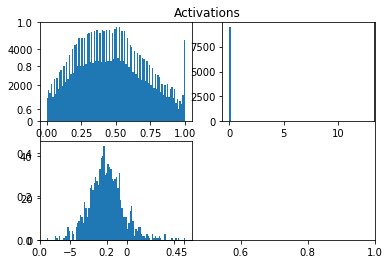

[3 8 2 7 9 8 9 4 7 2 2 9 8 7 9 8 9 8 2 5 5 8 9 8 8 9 6 4 8 3 6 0 4 5 2 6 1
 5 2 6 8 6 7 9 6 1 9 8 8 0 8 7 6 8 7 7 5 2 2 6 3 6 5 0 7 7 5 2 2 5 1 7 5 9
 9 2 5 8 1 7 4 2 8 6 6 5 7 2 5 5 6 9 8 2 1 0 9 4 8 5]
[ 4  5 14  3  5 14 12 12 18 13]
[6 1 6 ..., 5 3 6]
[ 229  365  786  153  220  595  708  497 1064  383]
cost: 32.32899642168784, train accuracy: 0.43, validation accuracy: 0.3778
iterations finished: 2601 alpha: 0.00059049 reg. lambda: 0.0


Weights 0 Mean -0.00107752207704 SD 0.027761746451
Weights 1 Mean -0.00155329803455 SD 0.147288746157


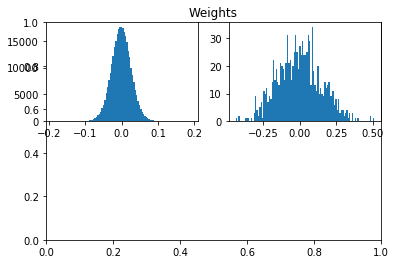

dW 0 Mean 0.00447131384173 SD 0.262087305813
dW 1 Mean 2.84217094304e-17 SD 2.78237138374


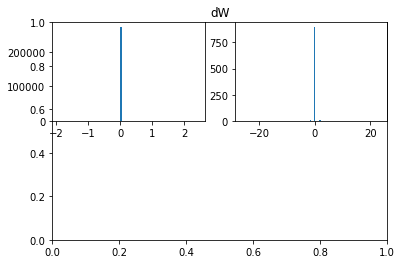

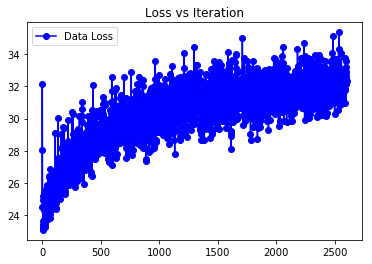

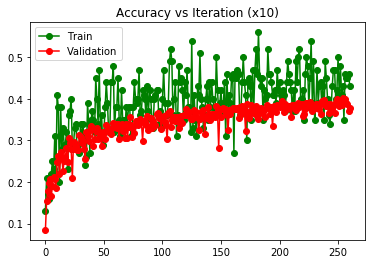

[2 7 5 2 5 3 1 2 4 7 5 5 9 1 5 2 5 2 2 5 0 9 3 9 7 7 0 5 0 2 9 8 7 2 7 3 2
 8 7 5 6 8 7 3 7 2 2 3 3 2 1 9 5 5 9 5 5 6 6 3 9 5 5 6 9 5 5 2 6 3 8 7 7 8
 2 7 0 7 9 6 3 1 7 7 7 2 7 3 8 3 6 5 2 3 6 3 5 5 2 9]
[ 4  4 17 13  1 20  8 17  6 10]
[5 7 6 ..., 5 5 6]
[293 191 826 401 148 900 527 797 388 529]
cost: 32.48088832330681, train accuracy: 0.36, validation accuracy: 0.3674
iterations finished: 2611 alpha: 0.00059049 reg. lambda: 0.0


[7 2 8 0 2 6 1 9 6 7 7 4 0 0 6 0 8 2 2 8 6 6 6 5 9 3 8 1 3 7 5 8 6 7 6 0 6
 6 6 2 4 7 7 0 0 0 6 6 6 0 3 4 6 6 6 3 1 8 7 6 2 7 0 7 6 7 8 8 6 2 4 4 8 0
 0 4 7 3 8 6 6 2 9 3 2 0 0 6 6 7 8 1 1 7 9 8 3 7 2 8]
[14  5 10  7  6  2 24 15 13  4]
[6 1 6 ..., 5 6 6]
[ 553  492  601  246  390  272 1007  576  622  241]
cost: 31.392325560364363, train accuracy: 0.45, validation accuracy: 0.3894
iterations finished: 2621 alpha: 0.00059049 reg. lambda: 0.0


[8 9 9 7 6 6 3 7 4 6 3 6 5 8 5 7 0 3 8 1 6 2 8 1 8 7 5 6 6 9 6 0 1 6 3 0 1
 9 0 6 5 0 5 7 9 6 8 8 0 9 9 2 8 6 0 1 9 4 4

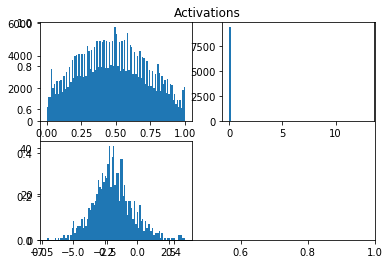

[9 1 8 0 0 6 5 6 4 5 8 8 7 8 9 3 8 8 6 3 6 7 5 6 3 6 6 2 9 8 3 2 4 6 8 5 8
 0 8 3 2 8 8 1 8 6 3 8 8 3 3 6 2 1 8 9 8 3 3 8 6 1 2 2 6 3 1 0 8 2 1 0 8 8
 8 6 3 7 3 2 9 9 3 3 8 7 7 8 8 1 6 8 6 3 8 3 3 6 5 8]
[ 5  7  8 18  2  5 16  5 28  6]
[6 9 6 ..., 5 6 6]
[ 204  275  396  955  174  329 1127  397  747  396]
cost: 32.886583222620956, train accuracy: 0.42, validation accuracy: 0.3684
iterations finished: 2701 alpha: 0.00059049 reg. lambda: 0.0


Weights 0 Mean -0.00105858020455 SD 0.0278043242263
Weights 1 Mean -0.00155329803455 SD 0.147534373467


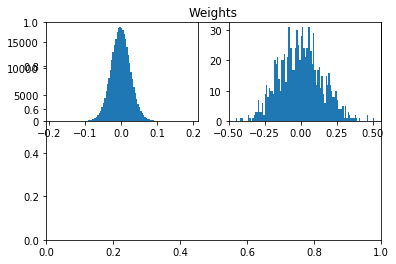

dW 0 Mean 0.00968824702865 SD 0.332806993912
dW 1 Mean -2.84217094304e-17 SD 2.38907511708


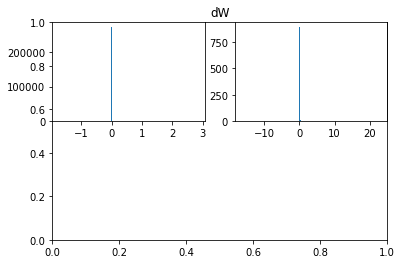

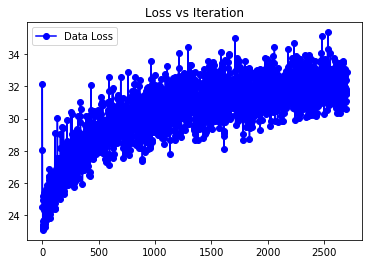

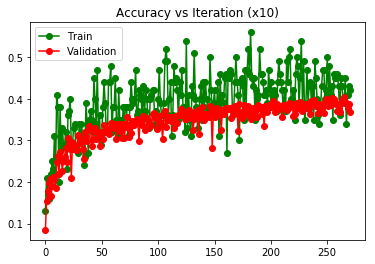

KeyboardInterrupt: 

In [13]:
np.random.seed(123456)
#layer_dimensions = [X_train.shape[0], 100, 50, 10]  # including the input and output layers #Really need to use MSRA or Glorot
#NN = NeuralNetwork(layer_dimensions, K_iters_alpha_drop=500, gamma=.90, do_reflection=False, standard_scaling=False)
#NN.train(X_train, y_train, iters=10000, alpha=0.001, batch_size=100, print_every=10)

layer_dimensions = [X_train.shape[0], 100, 10]  # including the input and output layers 
NN = NeuralNetwork(layer_dimensions, K_iters_alpha_drop=500, gamma=.90, do_reflection=True, standard_scaling=False)
NN.train(X_train, y_train, iters=10000, alpha=0.001, batch_size=100, print_every=10) #Using SD = .01

In [ ]:
y_predicted = NN.predict(X_test)
save_predictions('ans1-uni', y_predicted)

In [ ]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

## Part 2: Regularizing the neural network
#### Add dropout and L2 regularization

In [ ]:
y_predicted2 = NN2.predict(X_test)
save_predictions('ans2-uni',y_predicted)

In [ ]:
np.random.seed(123456)
layer_dimensions = [X_train.shape[0], 100, 10]  # including the input and output layers
NN2 = NeuralNetwork(layer_dimensions, drop_prob=.5, reg_lambda_L2=10., \
                    K_iters_alpha_drop=500, gamma=.90, do_reflection=True, standard_scaling=False)
NN2.train(X_train, y_train, iters=5000, alpha=0.0001, batch_size=100, print_every=10)#alpha=0.00001